In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import scipy.signal as signal
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.alexnet import alexnet
from time import time
seed=2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
reclist=glob("./seg/*")
dtlist=glob("./seg/*/*.npy*")
reclist.sort()
dtlist.sort()
lab_list=[seg.split('_')[0][-1] for seg in dtlist]#shuffle by idx
print(lab_list.count('A')/len(lab_list),lab_list.count('N')/len(lab_list))

#reclist=[rec for rec in reclist if rec[-3]!='b'] #Remove Borderline
reclist[0:5]

0.3807303354413779 0.6192696645586221


['./seg\\a01', './seg\\a02', './seg\\a03', './seg\\a04', './seg\\a05']

In [3]:
def cheb_bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #b, a = butter(filter_order, [low, high], btype="band")
        b, a = signal.cheby2(filter_order, 40, [low, high], 'band', analog=False)
        y = lfilter(b, a, data)
        return y

In [7]:
from sklearn.model_selection import KFold
def getTrainTestList(reclist,opt='rec_cv',fold=1):
    train_dtlist=[]
    test_dtlist=[]
    if opt=='rec_cv':#reclist is rec list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(reclist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_rec,test_rec=list(np.array(reclist)[train_idx]),list(np.array(reclist)[test_idx])
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        test_rec=[rec for rec in reclist if rec[-3]=='x']
        print(len(train_rec),len(test_rec))
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet_train':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        #print(len(train_rec),len(test_rec))
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
    elif opt=='blind':
        subjects=[['a11'],
                  ['a15','x27','x28'],
                  ['a17','x12'],
                  ['b01','x03'],
                  ['c07','x34'],
                  ['a11','a15','x27','x28','a17','x12','b01','x03','c07','x34'],
                  ['a14','a19','x05','x08','x25','b05','x11','c01','x35','c07','x34'],
                  ['a04','a19','x05','x08','x25','b05','x11','c01','x35','c09'],
                  ['b02','b03','x16','x21']]
        train_rec=[rec for rec in reclist if rec.split('/')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('/')[-1] in subjects[fold-1]]
        print(len(train_rec),len(test_rec),test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='leaveonepatient':
        # This is an additional experiment, so we have to
        #  use '\\' instead of '\'
        subjects=[
            ['a01','a14']
            ,['a02','x14']
            ,['a03','x19']
            ,['a04','a12']
            ,['a05','a10','a20','x07']
            ,['a06','x15']
            ,['a07','a16','x01','x30']
            ,['a08','a13','x20']
            ,['a09','a18']
            ,['a11']
            ,['a15','x27','x28']
            ,['a17','x12']
            ,['a19','x05','x08','x25']
            ,['b01','x03']
            ,['b02','b03','x16','x21']
            ,['b04','c08']
            ,['b05','x11']
            ,['c01','x35']
            ,['c02','c09']
            ,['c03','x04']
            ,['c04','x29']
            ,['c05','x33']
            ,['c06']
            ,['c07','x34']
            ,['c10','x18']
            ,['x02']
            ,['x06','x24']
            ,['x09','x23']
            ,['x10']
            ,['x13','x26']
            ,['x17','x22']
            ,['x31','x32']
        ]
        train_rec=[rec for rec in reclist if rec.split('\\')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('\\')[-1] in subjects[fold-1]]
        print('test subjects: ',test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')

    else:#reclist is npy data list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
         
    return train_dtlist,test_dtlist

def dtclean(dt_path):
    dt=np.load(dt_path)
    if dt.std()<0.1:
        #print(dt_path)
        return 1      
    else:
        return 0
#train_rec,test_rec=reclist[train_idx],reclist[test_idx]

In [8]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
ApneaECGDict={'N':0,
              'A':1}
class ApneaECGDataset(Dataset):
    def __init__(self, filelist, istrain=False):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain
        
    def getFeature(self, dt):
#         dt=dt.reshape(-1,100)
#         if self.istrain:
#             shift=np.random.randint(0,5)
#             shift=0
#         else:
#             shift=0
#         dt=dt[:,shift::]
#         dt_flag=dt[:,20::]*dt[:,0:-20]
#         pd_dt=pd.DataFrame(dt)
#         pd_dt_flag=pd.DataFrame(dt_flag)
#scipy.signal.stft(x,fs=1.0,window='hann',nperseg=256,noverlap=None,nfft=None,detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)
        dt=cheb_bandpass_filter(dt, 0.01, 38, 100, 4)
        f, t, Sxx=signal.spectrogram(dt, fs=100.0, window=('hamming'), nperseg=128, noverlap=64, nfft=128, detrend='constant',
        return_onesided=True, scaling='density', axis=-1, mode='psd')
        return Sxx[0:26]
        
#         return np.concatenate((dt_flag.max(axis=1,keepdims=True),
#                                dt_flag.min(axis=1,keepdims=True),
#                                dt_flag.std(axis=1,keepdims=True),
#                                dt.std(axis=1,keepdims=True),
#             abs(dt).sum(axis=1,keepdims=True)/100,
#             abs(dt_flag).sum(axis=1,keepdims=True)/100,
#             (dt.argmax(axis=1)-dt.argmax(axis=1)[0])[:,np.newaxis]/100,
#             (dt.argmin(axis=1)-dt.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmin(axis=1)-dt_flag.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmax(axis=1)-dt_flag.argmax(axis=1)[0])[:,np.newaxis]/100,
#                                dt.mean(axis=1,keepdims=True),#
#                                dt.min(axis=1,keepdims=True),
#                                dt.max(axis=1,keepdims=True),
#                                #pd_dt.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt.kurt(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.kurt(axis=1).values[:,np.newaxis]
#                                ),axis=1)
    def __getitem__(self, index):
        # return to the data of a Picture
        dt_path = self.filelist[index]
        label = ApneaECGDict.__getitem__(dt_path.split('_')[0][-1])
        data = np.load(dt_path)

        if self.istrain:#results are not reproducable when self.istrain =True due to a variation of random seed
            noise = np.random.normal(0, 0.1, data.shape[0])
            data = noise+data
        data=self.getFeature(data)
        return data, label

    def __len__(self):
        return len(self.filelist)

class conv3x3(nn.Module):#ACNet

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, 
                 padding=1, dilation=1, groups=1, padding_mode='zeros', bias=False, deploy=False):
        super(conv3x3, self).__init__()
        self.deploy=deploy
        if self.deploy:
            self.fused_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernel_size,kernel_size), stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=False, padding_mode=padding_mode)
# c=a.square_conv.weight.data.numpy().copy()
# c[:,:,1:2,:]=a.square_conv.weight.data[:,:,1:2,:,].numpy().copy()+a.hor_conv.weight.data[:,:,0:1,:,].numpy().copy()
# c[:,:,:,1:2]+=a.ver_conv.weight.data[:,:,:,0:1].numpy().copy()
# c-a.square_conv.weight.data.numpy()
# b.fused_conv.weight.data=torch.FloatTensor(c)    
        else:
            self.square_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=(kernel_size, kernel_size), stride=stride,
                                         padding=padding, dilation=dilation, groups=groups, bias=False,
                                         padding_mode=padding_mode)

            center_offset_from_origin_border = padding - kernel_size // 2 #1-3//2=0
            ver_pad_or_crop = (center_offset_from_origin_border + 1, center_offset_from_origin_border)
            hor_pad_or_crop = (center_offset_from_origin_border, center_offset_from_origin_border + 1)
            if center_offset_from_origin_border >= 0:
                self.ver_conv_crop_layer = nn.Identity()
                ver_conv_padding = ver_pad_or_crop
                self.hor_conv_crop_layer = nn.Identity()
                hor_conv_padding = hor_pad_or_crop

            self.ver_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 1),
                                      stride=stride,
                                      padding=ver_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

            self.hor_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 3),
                                      stride=stride,
                                      padding=hor_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

    # forward函数
    def forward(self, input):
        if self.deploy:
            #assert self.square_conv
            print("True")
            return self.fused_conv(input)
        square_outputs = self.square_conv(input)
        # print(square_outputs.size())
        # return square_outputs
        vertical_outputs = self.ver_conv(input)
        # print(vertical_outputs.size())
        #horizontal_outputs = self.hor_conv_crop_layer(input)
        horizontal_outputs = self.hor_conv(input)
        # print(horizontal_outputs.size())
        return square_outputs + vertical_outputs + horizontal_outputs
    
class MyLSTM(nn.Module):
    def __init__(self, class_num,fs):
        super(MyLSTM, self).__init__()
        #self.bn=nn.BatchNorm1d(60)
#         self.conv10=nn.Sequential(nn.Conv1d(1,64,kernel_size=10,stride=10,padding=0, bias=False),
#                   nn.Conv1d(64,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                   nn.Conv1d(32,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                                nn.ReLU())1200
#25 * 65
#12* 32
#b*64*6*16
#b*6*64*16
        self.branch1=nn.Sequential(nn.Conv2d(1,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
                                #nn.ReLU(),                               
                                nn.LayerNorm([64,26,92],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.25),
                                #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.25),
                                
#                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.25),
                                nn.LayerNorm([64,13,46],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5),
                                nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.5),
                                nn.LayerNorm([64,6,23],elementwise_affine=False),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
                                nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False))
        
#         self.branch2=nn.Sequential(nn.Conv2d(1,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
#                                 #nn.ReLU(),                               
#                                 nn.LayerNorm([32,25,92]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.25),
                                
# #                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
# #                                 nn.ReLU(),
# #                                 nn.Dropout(p=0.25),
#                                 nn.LayerNorm([32,12,46]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.5),
#                                 nn.LayerNorm([32,6,23]),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.5),
#                                 #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False))
        
        self.avg = nn.Sequential(nn.AdaptiveMaxPool2d((8,8)),nn.LayerNorm([6,8,8],elementwise_affine=False))
    
        self.lstm = nn.LSTM(64, 8, 2,
                            bias=False,
                            batch_first=True,
                            dropout=0.5,
                            bidirectional=True)
        #self.conv2=nn.Sequential(nn.Conv1d(64,64,kernel_size=1,stride=1,padding=0, bias=False))
        
        self.fc=nn.Sequential(nn.Linear(16*2,class_num))
    def attention_net(self,lstm_output, final_state):
        hidden = final_state.view(-1, 16, 2)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print('hi',hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        #print('att',attn_weights.shape)
        soft_attn_weights = F.softmax(attn_weights, 1)
        #print('sft',soft_attn_weights.shape)
        #print('yimr',torch.bmm(lstm_output.transpose(1, 2),soft_attn_weights).shape)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context#, soft_attn_weights.data.cpu().numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    def forward(self, x):
        x=x.unsqueeze(dim=1)#x.reshape(x.shape[0],1,-1)
        #x1=self.conv10(x)
        out=self.branch1(x)
        #out_1=self.branch1(x)
        #out_2=self.branch2(x)
        #out=torch.cat((out_1,out_2),1)
        #print(out.shape)
        out=out.permute(0,2,1,3)
        out=self.avg(out)
        #print(out.shape)
        out=out.view(out.shape[0],out.shape[1],-1)
        #print(x2.shape)
        #print(x1.shape,x2.shape)
        #x=torch.cat((x1,x2),dim=1)
        #print(x.shape)
        out,(h,c) = self.lstm(out)
        out=self.attention_net(out, h)
        
        #out = self.conv2(out)
        #print(out.shape)
        out = self.fc(out.reshape(out.shape[0],-1))
        return out#,attn

In [9]:
# #Find mean and std for normalization
# train_dataset = ApneaECGDataset(train_dtlist+test_dtlist,istrain=False)
#     #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
# train_loader=DataLoader(train_dataset, batch_size=256, shuffle=False, sampler=None, num_workers=0)
# fe_list=torch.Tensor([])
# label_list=torch.LongTensor([])
# for fe, label in train_loader:
#     fe=fe.float()
#     label=label.long()
#     fe_list=torch.cat((fe_list,fe.reshape(-1,fe.shape[-1])))
#     label_list=torch.cat((label_list,label))
# fe_mean=fe_list.mean(axis=0)
# fe_std=fe_list.std(axis=0)#,fe.shape

# label_list=label_list.numpy()
# pos=sum(label_list)#/len(label_list.numpy())
# neg=len(label_list)-pos
# c_weight=torch.Tensor([pos,neg])/len(label_list)#反比

# print(fe_mean,fe_std,c_weight)

In [10]:
# fe.shape
# ?signal.spectrogram

In [11]:
# m=nn.Conv2d(1,64,kernel_size=(1,3),dilation=1,stride=(1,2),padding=0, bias=False)
# n=nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=(1,2),padding=0, bias=False)
# fe.shape,fe.unsqueeze(dim=1).shape,n(m(fe.unsqueeze(dim=1))).shape,model(fe).shape

In [12]:
# plt.imshow(np.corrcoef(fe_list.numpy(),rowvar=False),cmap='coolwarm')
# plt.colorbar()
# plt.show()
# plt.close("all")
# model=alexnet(num_classes=2)
# model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
# model

In [13]:
def eval(model,test_dtlist,criterion):
    test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    test_loader=DataLoader(test_dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0)
    #train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
        #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    #train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
    sft=nn.Softmax().to(device)
    all_pred_prob=torch.Tensor([]).to(device)
    all_label=torch.Tensor([]).long().to(device)
    flag=0
    with torch.no_grad():
        for fe, label in test_loader:
            fe=fe.float().to(device)
            #fe=(fe-fe_mean)/fe_std
            label=label.long().to(device)
            pred_prob_no_softmax =model(fe)
            all_pred_prob=torch.cat((all_pred_prob,pred_prob_no_softmax),0)
            all_label=torch.cat((all_label,label),0)
            
            loss=criterion(pred_prob_no_softmax,label)
            flag+=1
            if flag%8192==0:
                print('Eval Loss: ',loss.item())
            #pos=(sft(pred_prob_no_softmax)[:,1]>0.5)
            #print("Acc: ", sum(label==pos).detach().numpy()/len(label))
    all_pred=sft(all_pred_prob)[:,1].detach().cpu().numpy()
    all_pred[all_pred>0.5]=1
    all_pred[all_pred<=0.5]=0
    all_label=all_label.detach().cpu().numpy()

    print(confusion_matrix(all_label,all_pred))
    print(classification_report(all_label,all_pred))
    print("acc: ",accuracy_score(all_label,all_pred))
    print("pre: ",precision_score(all_label,all_pred))
    print("rec: ",recall_score(all_label,all_pred))
    print("ma F1: ",f1_score(all_label,all_pred, average='macro'))
    print("mi F1: ",f1_score(all_label,all_pred, average='micro'))
    print("we F1: ",f1_score(all_label,all_pred, average='weighted'))
    return accuracy_score(all_label,all_pred)

test subjects:  ['./seg\\a01', './seg\\a14']
*********
33315 998
31893 998
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6684489250183105
Eval Loss:  0.7222466468811035
Eval Loss:  0.6797828078269958


D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 2798 17221]
 [ 2933  8941]]
              precision    recall  f1-score   support

           0       0.49      0.14      0.22     20019
           1       0.34      0.75      0.47     11874

    accuracy                           0.37     31893
   macro avg       0.41      0.45      0.34     31893
weighted avg       0.43      0.37      0.31     31893

acc:  0.36807449910638695
pre:  0.3417552174910175
rec:  0.7529897254505643
ma F1:  0.3437269730158552
mi F1:  0.36807449910638695
we F1:  0.31144460283721587
[[ 48  97]
 [355 498]]
              precision    recall  f1-score   support

           0       0.12      0.33      0.18       145
           1       0.84      0.58      0.69       853

    accuracy                           0.55       998
   macro avg       0.48      0.46      0.43       998
weighted avg       0.73      0.55      0.61       998

acc:  0.5470941883767535
pre:  0.8369747899159664
rec:  0.5838218053927315
ma F1:  0.43151389280961405
mi F1:  0.5470941883767535
we 

Loss:  0.05494740232825279
Loss:  0.07942625135183334
Loss:  0.07244600355625153
15 **********
epoch:  16
Loss:  0.11197512596845627
Loss:  0.04531416296958923
Loss:  0.05306907743215561
16 **********
epoch:  17
Loss:  0.05756701901555061
Loss:  0.06613649427890778
Loss:  0.05577581748366356
17 **********
epoch:  18
Eval Loss:  2.2524945735931396
Eval Loss:  0.04508793354034424
Eval Loss:  0.15590554475784302
[[19350   669]
 [ 3317  8557]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     20019
           1       0.93      0.72      0.81     11874

    accuracy                           0.88     31893
   macro avg       0.89      0.84      0.86     31893
weighted avg       0.88      0.88      0.87     31893

acc:  0.8750195967767221
pre:  0.9274875352265337
rec:  0.7206501600134748
ma F1:  0.8588552425037856
mi F1:  0.8750195967767221
we F1:  0.8710537661351271
[[ 96  49]
 [202 651]]
              precision    recall  f1-score   supp

[[ 69  76]
 [ 88 765]]
              precision    recall  f1-score   support

           0       0.44      0.48      0.46       145
           1       0.91      0.90      0.90       853

    accuracy                           0.84       998
   macro avg       0.67      0.69      0.68       998
weighted avg       0.84      0.84      0.84       998

acc:  0.8356713426853707
pre:  0.9096313912009513
rec:  0.8968347010550997
ma F1:  0.6800706818768227
mi F1:  0.8356713426853707
we F1:  0.8383541126993113
Loss:  0.07124912738800049
Loss:  0.05556640401482582
Loss:  0.041635893285274506
33 **********
epoch:  34
Loss:  0.08024516701698303
Loss:  0.0910240039229393
Loss:  0.07312063872814178
34 **********
epoch:  35
Loss:  0.0531756728887558
Loss:  0.04534219205379486
Loss:  0.04298719763755798
35 **********
epoch:  36
Eval Loss:  1.6014165878295898
Eval Loss:  0.06640326976776123
Eval Loss:  0.09109342098236084
[[19116   903]
 [ 2159  9715]]
              precision    recall  f1-score   suppo

[[ 78  67]
 [128 725]]
              precision    recall  f1-score   support

           0       0.38      0.54      0.44       145
           1       0.92      0.85      0.88       853

    accuracy                           0.80       998
   macro avg       0.65      0.69      0.66       998
weighted avg       0.84      0.80      0.82       998

acc:  0.8046092184368737
pre:  0.9154040404040404
rec:  0.8499413833528722
ma F1:  0.662951705504897
mi F1:  0.8046092184368737
we F1:  0.8179648726700276
Loss:  0.05966540426015854
Loss:  0.072503961622715
Loss:  0.06168914958834648
51 **********
epoch:  52
Loss:  0.053672682493925095
Loss:  0.053890109062194824
Loss:  0.053078725934028625
52 **********
epoch:  53
Loss:  0.0546586737036705
Loss:  0.05181866139173508
Loss:  0.08489358425140381
53 **********
epoch:  54
Eval Loss:  1.287349820137024
Eval Loss:  0.07895827293395996
Eval Loss:  0.07218170166015625
[[19257   762]
 [ 2083  9791]]
              precision    recall  f1-score   suppor

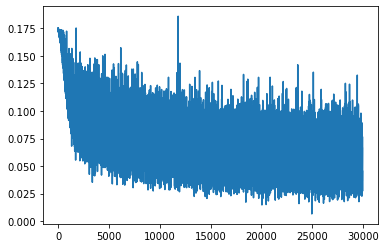

------
Subject:  1 Training Time 5756.250954389572 Best Test Acc:  0.8496993987975952
test subjects:  ['./seg\\a02', './seg\\x14']
*********
33295 1018
31873 1018
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6054941415786743
Eval Loss:  0.6315019130706787
Eval Loss:  0.6349784731864929
[[19891   114]
 [11711   157]]
              precision    recall  f1-score   support

           0       0.63      0.99      0.77     20005
           1       0.58      0.01      0.03     11868

    accuracy                           0.63     31873
   macro avg       0.60      0.50      0.40     31873
weighted avg       0.61      0.63      0.49     31873

acc:  0.6289963291814389
pre:  0.579335793357

[[154   5]
 [721 138]]
              precision    recall  f1-score   support

           0       0.18      0.97      0.30       159
           1       0.97      0.16      0.28       859

    accuracy                           0.29      1018
   macro avg       0.57      0.56      0.29      1018
weighted avg       0.84      0.29      0.28      1018

acc:  0.2868369351669941
pre:  0.965034965034965
rec:  0.16065192083818394
ma F1:  0.2866607211109695
mi F1:  0.2868369351669941
we F1:  0.27895135615989525
Loss:  0.06788226962089539
Loss:  0.1084505096077919
Loss:  0.05324641615152359
15 **********
epoch:  16
Loss:  0.07953336834907532
Loss:  0.05617992952466011
Loss:  0.09775302559137344
16 **********
epoch:  17
Loss:  0.07792703807353973
Loss:  0.09677634388208389
Loss:  0.09355318546295166
17 **********
epoch:  18
Eval Loss:  0.021998882293701172
Eval Loss:  0.03615772724151611
Eval Loss:  0.0037755966186523438
[[19026   979]
 [ 2254  9614]]
              precision    recall  f1-score   

[[144  15]
 [638 221]]
              precision    recall  f1-score   support

           0       0.18      0.91      0.31       159
           1       0.94      0.26      0.40       859

    accuracy                           0.36      1018
   macro avg       0.56      0.58      0.35      1018
weighted avg       0.82      0.36      0.39      1018

acc:  0.35854616895874264
pre:  0.9364406779661016
rec:  0.2572759022118743
ma F1:  0.35485517689817986
mi F1:  0.3585461689587427
we F1:  0.38840965017602364
Loss:  0.05965542048215866
Loss:  0.08562697470188141
Loss:  0.06587574630975723
33 **********
epoch:  34
Loss:  0.06029229611158371
Loss:  0.043907955288887024
Loss:  0.0842248946428299
34 **********
epoch:  35
Loss:  0.07114464789628983
Loss:  0.028487619012594223
Loss:  0.06536387652158737
35 **********
epoch:  36
Eval Loss:  0.033109426498413086
Eval Loss:  0.05152738094329834
Eval Loss:  0.0016636848449707031
[[18238  1767]
 [ 1172 10696]]
              precision    recall  f1-scor

[[18006  1999]
 [  851 11017]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     20005
           1       0.85      0.93      0.89     11868

    accuracy                           0.91     31873
   macro avg       0.90      0.91      0.91     31873
weighted avg       0.91      0.91      0.91     31873

acc:  0.9105826247921438
pre:  0.8464197910264291
rec:  0.9282945736434108
ma F1:  0.9060660765007842
mi F1:  0.9105826247921438
we F1:  0.9113245045229322
[[120  39]
 [482 377]]
              precision    recall  f1-score   support

           0       0.20      0.75      0.32       159
           1       0.91      0.44      0.59       859

    accuracy                           0.49      1018
   macro avg       0.55      0.60      0.45      1018
weighted avg       0.80      0.49      0.55      1018

acc:  0.48821218074656186
pre:  0.90625
rec:  0.43888242142025613
ma F1:  0.4533735281234702
mi F1:  0.48821218074656186
we F1:  0.54826

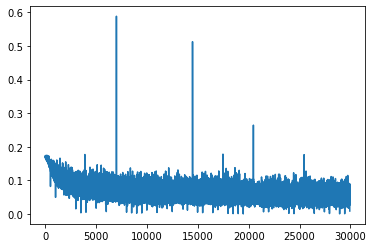

------
Subject:  2 Training Time 5770.963615894318 Best Test Acc:  0.5009823182711198
test subjects:  ['./seg\\a03', './seg\\x19']
*********
33307 1006
31885 1006
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8116292953491211
Eval Loss:  0.7895532250404358
Eval Loss:  0.8268351554870605
[[    0 19811]
 [    0 12074]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19811
           1       0.38      1.00      0.55     12074

    accuracy                           0.38     31885
   macro avg       0.19      0.50      0.27     31885
weighted avg       0.14      0.38      0.21     31885

acc:  0.37867335737807745
pre:  0.37867335737

D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0 353]
 [  0 653]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       353
           1       0.65      1.00      0.79       653

    accuracy                           0.65      1006
   macro avg       0.32      0.50      0.39      1006
weighted avg       0.42      0.65      0.51      1006

acc:  0.6491053677932406
pre:  0.6491053677932406
rec:  1.0
ma F1:  0.3936106088004822
mi F1:  0.6491053677932406
we F1:  0.5109895179855166
Subject 3 Current Train Acc:  0.37867335737807745 Current Test Acc:  0.6491053677932406
Loss:  0.17041602730751038
Loss:  0.16309350728988647
Loss:  0.16367478668689728
0 **********
epoch:  1
Loss:  0.1280374675989151
Loss:  0.13905373215675354
Loss:  0.13234946131706238
1 **********
epoch:  2
Loss:  0.14415547251701355
Loss:  0.09496816992759705
Loss:  0.10203898698091507
2 **********
epoch:  3
Eval Loss:  0.06100630760192871
Eval Loss:  0.034014225006103516
Eval Loss:  0.023370981216430664
[[16634  317

Eval Loss:  0.0072176456451416016
Eval Loss:  0.004019975662231445
Eval Loss:  0.0031130313873291016
[[18747  1064]
 [ 2254  9820]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     19811
           1       0.90      0.81      0.86     12074

    accuracy                           0.90     31885
   macro avg       0.90      0.88      0.89     31885
weighted avg       0.90      0.90      0.89     31885

acc:  0.8959385290889132
pre:  0.9022418228592429
rec:  0.813317873115786
ma F1:  0.8870877989258166
mi F1:  0.8959385290889132
we F1:  0.8947586961221736
[[324  29]
 [179 474]]
              precision    recall  f1-score   support

           0       0.64      0.92      0.76       353
           1       0.94      0.73      0.82       653

    accuracy                           0.79      1006
   macro avg       0.79      0.82      0.79      1006
weighted avg       0.84      0.79      0.80      1006

acc:  0.7932405566600398
pre:  0.942

Loss:  0.0469401590526104
Loss:  0.06073326990008354
Loss:  0.04116009920835495
33 **********
epoch:  34
Loss:  0.07276497036218643
Loss:  0.0491732582449913
Loss:  0.07254333049058914
34 **********
epoch:  35
Loss:  0.04603331536054611
Loss:  0.04539577662944794
Loss:  0.07203417271375656
35 **********
epoch:  36
Eval Loss:  0.0031783580780029297
Eval Loss:  0.0011696815490722656
Eval Loss:  0.0013804435729980469
[[18808  1003]
 [ 1858 10216]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     19811
           1       0.91      0.85      0.88     12074

    accuracy                           0.91     31885
   macro avg       0.91      0.90      0.90     31885
weighted avg       0.91      0.91      0.91     31885

acc:  0.9102712874392348
pre:  0.9105980925216152
rec:  0.8461156203412291
ma F1:  0.9032456419821882
mi F1:  0.9102712874392349
we F1:  0.9095721572174268
[[309  44]
 [112 541]]
              precision    recall  f1-score  

[[288  65]
 [ 77 576]]
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       353
           1       0.90      0.88      0.89       653

    accuracy                           0.86      1006
   macro avg       0.84      0.85      0.85      1006
weighted avg       0.86      0.86      0.86      1006

acc:  0.8588469184890656
pre:  0.8985959438377535
rec:  0.8820826952526799
ma F1:  0.8462455817077319
mi F1:  0.8588469184890656
we F1:  0.8593719741882879
Subject 3 Current Train Acc:  0.9203387172651717 Current Test Acc:  0.8588469184890656
Loss:  0.062479205429553986
Loss:  0.078945092856884
Loss:  0.050740472972393036
51 **********
epoch:  52
Loss:  0.03553767874836922
Loss:  0.058991171419620514
Loss:  0.05758526176214218
52 **********
epoch:  53
Loss:  0.08994396775960922
Loss:  0.06029357761144638
Loss:  0.06265679001808167
53 **********
epoch:  54
Eval Loss:  0.002053976058959961
Eval Loss:  0.0008327960968017578
Eval Loss:  0.0010676

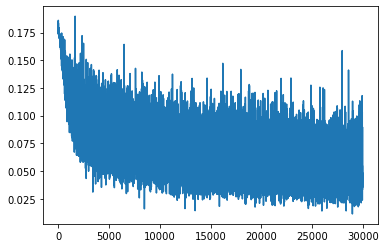

------
Subject:  3 Training Time 5810.173776388168 Best Test Acc:  0.8588469184890656
test subjects:  ['./seg\\a04', './seg\\a12']
*********
33244 1069
32160 731
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.5566058158874512
Eval Loss:  0.8447078466415405
Eval Loss:  0.5683379173278809
[[20104     0]
 [12056     0]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     20104
           1       0.00      0.00      0.00     12056

    accuracy                           0.63     32160
   macro avg       0.31      0.50      0.38     32160
weighted avg       0.39      0.63      0.48     32160

acc:  0.6251243781094528
pre:  0.0
rec:  0.0
m

D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 60   0]
 [671   0]]
              precision    recall  f1-score   support

           0       0.08      1.00      0.15        60
           1       0.00      0.00      0.00       671

    accuracy                           0.08       731
   macro avg       0.04      0.50      0.08       731
weighted avg       0.01      0.08      0.01       731

acc:  0.08207934336525308
pre:  0.0
rec:  0.0
ma F1:  0.07585335018963336
mi F1:  0.08207934336525308
we F1:  0.012451986351239402
Subject 4 Current Train Acc:  0.6251243781094528 Current Test Acc:  0.08207934336525308
Loss:  0.15527421236038208
Loss:  0.16259485483169556
Loss:  0.14117708802223206
0 **********
epoch:  1
Loss:  0.13147927820682526
Loss:  0.12404484301805496
Loss:  0.11476148664951324
1 **********
epoch:  2
Loss:  0.1010369062423706
Loss:  0.12150849401950836
Loss:  0.10488597303628922
2 **********
epoch:  3
Eval Loss:  0.032297611236572266
Eval Loss:  0.3539867103099823
Eval Loss:  0.7020819187164307
[[16621  3483]
 [ 2523  9

[[ 60   0]
 [345 326]]
              precision    recall  f1-score   support

           0       0.15      1.00      0.26        60
           1       1.00      0.49      0.65       671

    accuracy                           0.53       731
   macro avg       0.57      0.74      0.46       731
weighted avg       0.93      0.53      0.62       731

acc:  0.5280437756497948
pre:  1.0
rec:  0.4858420268256334
ma F1:  0.45601320089300157
mi F1:  0.5280437756497948
we F1:  0.6214668895260868
Loss:  0.054590918123722076
Loss:  0.052174102514982224
Loss:  0.06518105417490005
18 **********
epoch:  19
Loss:  0.045638859272003174
Loss:  0.023533092811703682
Loss:  0.05878020450472832
19 **********
epoch:  20
Loss:  0.0640261173248291
Loss:  0.04909495264291763
Loss:  0.0646742731332779
20 **********
epoch:  21
Eval Loss:  0.03912174701690674
Eval Loss:  0.4678824245929718
Eval Loss:  0.046666741371154785
[[19288   816]
 [ 2645  9411]]
              precision    recall  f1-score   support

      

[[ 56   4]
 [214 457]]
              precision    recall  f1-score   support

           0       0.21      0.93      0.34        60
           1       0.99      0.68      0.81       671

    accuracy                           0.70       731
   macro avg       0.60      0.81      0.57       731
weighted avg       0.93      0.70      0.77       731

acc:  0.7017783857729138
pre:  0.9913232104121475
rec:  0.6810730253353204
ma F1:  0.573407217046793
mi F1:  0.7017783857729138
we F1:  0.7690051823626529
Loss:  0.05506144464015961
Loss:  0.05899607390165329
Loss:  0.06883640587329865
36 **********
epoch:  37
Loss:  0.053105052560567856
Loss:  0.052979692816734314
Loss:  0.05155421048402786
37 **********
epoch:  38
Loss:  0.03922662138938904
Loss:  0.057934705168008804
Loss:  0.06192786619067192
38 **********
epoch:  39
Eval Loss:  0.07701599597930908
Eval Loss:  0.8036577105522156
Eval Loss:  0.2173340916633606
[[19166   938]
 [ 1943 10113]]
              precision    recall  f1-score   sup

[[ 56   4]
 [407 264]]
              precision    recall  f1-score   support

           0       0.12      0.93      0.21        60
           1       0.99      0.39      0.56       671

    accuracy                           0.44       731
   macro avg       0.55      0.66      0.39       731
weighted avg       0.91      0.44      0.53       731

acc:  0.4377564979480164
pre:  0.9850746268656716
rec:  0.39344262295081966
ma F1:  0.3882247295340839
mi F1:  0.43775649794801635
we F1:  0.5337242992500106
Loss:  0.08340386301279068
Loss:  0.055607449263334274
Loss:  0.07277020812034607
54 **********
epoch:  55
Loss:  0.052634112536907196
Loss:  0.05200750753283501
Loss:  0.02919716015458107
55 **********
epoch:  56
Loss:  0.04002414643764496
Loss:  0.0674293041229248
Loss:  0.10678774863481522
56 **********
epoch:  57
Eval Loss:  0.029600858688354492
Eval Loss:  0.26270872354507446
Eval Loss:  0.28981056809425354
[[19239   865]
 [ 1611 10445]]
              precision    recall  f1-score  

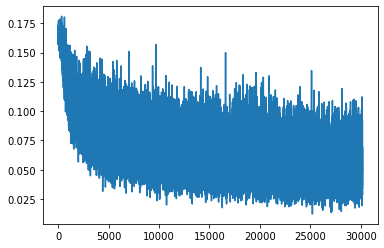

------
Subject:  4 Training Time 5802.136266469955 Best Test Acc:  0.7893296853625171
test subjects:  ['./seg\\a05', './seg\\a10', './seg\\a20', './seg\\x07']
*********
32323 1990
30901 1990
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6534038186073303
Eval Loss:  0.6341980695724487
Eval Loss:  0.646928071975708
[[16949  2156]
 [ 9958  1838]]
              precision    recall  f1-score   support

           0       0.63      0.89      0.74     19105
           1       0.46      0.16      0.23     11796

    accuracy                           0.61     30901
   macro avg       0.55      0.52      0.48     30901
weighted avg       0.57      0.61      0.54     30901

acc:  0.6079738519

[[18492   613]
 [ 3218  8578]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     19105
           1       0.93      0.73      0.82     11796

    accuracy                           0.88     30901
   macro avg       0.89      0.85      0.86     30901
weighted avg       0.88      0.88      0.87     30901

acc:  0.8760234296624705
pre:  0.9333043194429334
rec:  0.7271956595456087
ma F1:  0.861797938056087
mi F1:  0.8760234296624705
we F1:  0.8722855432760847
[[878 181]
 [416 515]]
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1059
           1       0.74      0.55      0.63       931

    accuracy                           0.70      1990
   macro avg       0.71      0.69      0.69      1990
weighted avg       0.71      0.70      0.69      1990

acc:  0.7
pre:  0.7399425287356322
rec:  0.5531686358754028
ma F1:  0.6896741687173862
mi F1:  0.7
we F1:  0.6933152331916963
Loss:  0.05

Loss:  0.0563637837767601
Loss:  0.05974331125617027
30 **********
epoch:  31
Loss:  0.0804901048541069
Loss:  0.08616647869348526
Loss:  0.04320260137319565
31 **********
epoch:  32
Loss:  0.06047957018017769
Loss:  0.1314544379711151
Loss:  0.05584467574954033
32 **********
epoch:  33
Eval Loss:  0.0020759105682373047
Eval Loss:  0.006057262420654297
Eval Loss:  0.02718937397003174
[[18090  1015]
 [ 1604 10192]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     19105
           1       0.91      0.86      0.89     11796

    accuracy                           0.92     30901
   macro avg       0.91      0.91      0.91     30901
weighted avg       0.92      0.92      0.91     30901

acc:  0.9152454613119316
pre:  0.9094316052467208
rec:  0.8640217022719566
ma F1:  0.9093217728309984
mi F1:  0.9152454613119316
we F1:  0.9148036972558075
[[726 333]
 [363 568]]
              precision    recall  f1-score   support

           0       0.

Loss:  0.06368640065193176
Loss:  0.0409354642033577
Loss:  0.03855869174003601
48 **********
epoch:  49
Loss:  0.053611479699611664
Loss:  0.09974689781665802
Loss:  0.04250288009643555
49 **********
epoch:  50
Loss:  0.024438275024294853
Loss:  0.04342386871576309
Loss:  0.05851375684142113
50 **********
epoch:  51
Eval Loss:  0.002016782760620117
Eval Loss:  0.040557026863098145
Eval Loss:  0.06936705112457275
[[17623  1482]
 [  847 10949]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     19105
           1       0.88      0.93      0.90     11796

    accuracy                           0.92     30901
   macro avg       0.92      0.93      0.92     30901
weighted avg       0.93      0.92      0.92     30901

acc:  0.9246302708650206
pre:  0.8807819161772987
rec:  0.928195998643608
ma F1:  0.9209424422436481
mi F1:  0.9246302708650206
we F1:  0.924981150573527
[[399 660]
 [274 657]]
              precision    recall  f1-score   su

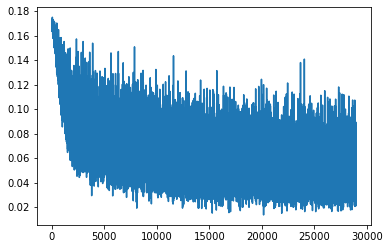

------
Subject:  5 Training Time 5680.420709133148 Best Test Acc:  0.7155778894472362
test subjects:  ['./seg\\a06', './seg\\x15']
*********
33305 1008
31883 1008
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8026854395866394
Eval Loss:  0.5899487733840942
Eval Loss:  0.7721058130264282
[[    0 19562]
 [    0 12321]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19562
           1       0.39      1.00      0.56     12321

    accuracy                           0.39     31883
   macro avg       0.19      0.50      0.28     31883
weighted avg       0.15      0.39      0.22     31883

acc:  0.3864441865570994
pre:  0.386444186557

[[602   0]
 [334  72]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       602
           1       1.00      0.18      0.30       406

    accuracy                           0.67      1008
   macro avg       0.82      0.59      0.54      1008
weighted avg       0.79      0.67      0.59      1008

acc:  0.6686507936507936
pre:  1.0
rec:  0.17733990147783252
ma F1:  0.5420450402903298
mi F1:  0.6686507936507936
we F1:  0.588865281155709
Loss:  0.05351709946990013
Loss:  0.04542950168251991
Loss:  0.07087201625108719
15 **********
epoch:  16
Loss:  0.06763684004545212
Loss:  0.04807901754975319
Loss:  0.049881674349308014
16 **********
epoch:  17
Loss:  0.054911334067583084
Loss:  0.07946427166461945
Loss:  0.07437507063150406
17 **********
epoch:  18
Eval Loss:  0.09389352798461914
Eval Loss:  0.6571735739707947
Eval Loss:  0.012449264526367188
[[18720   842]
 [ 3031  9290]]
              precision    recall  f1-score   support

       

Eval Loss:  0.02996659278869629
[[18761   801]
 [ 2233 10088]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     19562
           1       0.93      0.82      0.87     12321

    accuracy                           0.90     31883
   macro avg       0.91      0.89      0.90     31883
weighted avg       0.91      0.90      0.90     31883

acc:  0.9048395696766302
pre:  0.9264395261272844
rec:  0.8187647106566025
ma F1:  0.8972351717418279
mi F1:  0.9048395696766302
we F1:  0.903584006683129
[[473 129]
 [160 246]]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       602
           1       0.66      0.61      0.63       406

    accuracy                           0.71      1008
   macro avg       0.70      0.70      0.70      1008
weighted avg       0.71      0.71      0.71      1008

acc:  0.7132936507936508
pre:  0.656
rec:  0.6059113300492611
ma F1:  0.6979767452710374
mi F1:  0.713293

Loss:  0.07034910470247269
Loss:  0.055760763585567474
Loss:  0.05778679996728897
48 **********
epoch:  49
Loss:  0.07714997977018356
Loss:  0.04999712109565735
Loss:  0.011895699426531792
49 **********
epoch:  50
Loss:  0.05789926275610924
Loss:  0.06364940106868744
Loss:  0.05325448885560036
50 **********
epoch:  51
Eval Loss:  1.2064781188964844
Eval Loss:  0.08079159259796143
Eval Loss:  0.09115147590637207
[[17951  1611]
 [ 1023 11298]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     19562
           1       0.88      0.92      0.90     12321

    accuracy                           0.92     31883
   macro avg       0.91      0.92      0.91     31883
weighted avg       0.92      0.92      0.92     31883

acc:  0.9173854405168899
pre:  0.8752033465024401
rec:  0.9169710250791332
ma F1:  0.9136244022298158
mi F1:  0.9173854405168899
we F1:  0.9177178455240745
[[509  93]
 [ 92 314]]
              precision    recall  f1-score   su

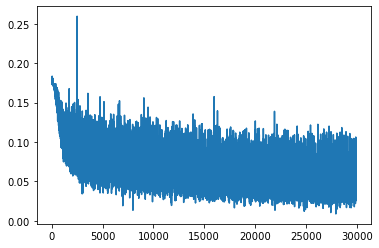

------
Subject:  6 Training Time 5777.847210645676 Best Test Acc:  0.8234126984126984
test subjects:  ['./seg\\a07', './seg\\a16', './seg\\x01', './seg\\x30']
*********
32286 2027
30874 2017
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7214403748512268
Eval Loss:  0.6637871861457825
Eval Loss:  0.7323856353759766
[[ 1197 18293]
 [ 1189 10195]]
              precision    recall  f1-score   support

           0       0.50      0.06      0.11     19490
           1       0.36      0.90      0.51     11384

    accuracy                           0.37     30874
   macro avg       0.43      0.48      0.31     30874
weighted avg       0.45      0.37      0.26     30874

acc:  0.368983610

[[ 456  218]
 [ 172 1171]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       674
           1       0.84      0.87      0.86      1343

    accuracy                           0.81      2017
   macro avg       0.78      0.77      0.78      2017
weighted avg       0.80      0.81      0.80      2017

acc:  0.8066435299950422
pre:  0.8430525557955364
rec:  0.8719285182427401
ma F1:  0.7788541336338058
mi F1:  0.8066435299950422
we F1:  0.8048556807186549
Subject 7 Current Train Acc:  0.8853080261708881 Current Test Acc:  0.8066435299950422
Loss:  0.106001116335392
Loss:  0.07625915855169296
Loss:  0.05805701017379761
15 **********
epoch:  16
Loss:  0.0598566047847271
Loss:  0.05334740877151489
Loss:  0.07365667074918747
16 **********
epoch:  17
Loss:  0.11144693195819855
Loss:  0.0890921875834465
Loss:  0.05660754814743996
17 **********
epoch:  18
Eval Loss:  0.019910812377929688
Eval Loss:  0.15572011470794678
Eval Loss:  0.2404773235

Eval Loss:  0.12086188793182373
Eval Loss:  0.20157063007354736
[[18033  1457]
 [ 1261 10123]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     19490
           1       0.87      0.89      0.88     11384

    accuracy                           0.91     30874
   macro avg       0.90      0.91      0.91     30874
weighted avg       0.91      0.91      0.91     30874

acc:  0.9119647599922265
pre:  0.8741796200345423
rec:  0.889230498945889
ma F1:  0.9057801917896459
mi F1:  0.9119647599922265
we F1:  0.9121180059299896
[[ 374  300]
 [ 115 1228]]
              precision    recall  f1-score   support

           0       0.76      0.55      0.64       674
           1       0.80      0.91      0.86      1343

    accuracy                           0.79      2017
   macro avg       0.78      0.73      0.75      2017
weighted avg       0.79      0.79      0.78      2017

acc:  0.7942488844819038
pre:  0.8036649214659686
rec:  0.91437081161

Loss:  0.05220770463347435
Loss:  0.0584288127720356
Loss:  0.07323186844587326
48 **********
epoch:  49
Loss:  0.0470334030687809
Loss:  0.06434682756662369
Loss:  0.057004787027835846
49 **********
epoch:  50
Loss:  0.04170054942369461
Loss:  0.05614311248064041
Loss:  0.03633546084165573
50 **********
epoch:  51
Eval Loss:  0.053082823753356934
Eval Loss:  0.09293568134307861
Eval Loss:  0.06871592998504639
[[18075  1415]
 [ 1042 10342]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     19490
           1       0.88      0.91      0.89     11384

    accuracy                           0.92     30874
   macro avg       0.91      0.92      0.92     30874
weighted avg       0.92      0.92      0.92     30874

acc:  0.9204184750923107
pre:  0.8796461682401974
rec:  0.9084680252986648
ma F1:  0.9150917522656508
mi F1:  0.9204184750923107
we F1:  0.9206754087033729
[[ 400  274]
 [ 152 1191]]
              precision    recall  f1-score  

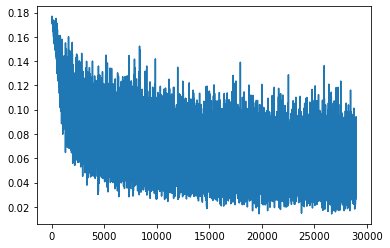

------
Subject:  7 Training Time 5747.030290603638 Best Test Acc:  0.8150718889439762
test subjects:  ['./seg\\a08', './seg\\a13', './seg\\x20']
*********
32804 1509
31386 1505
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.669914722442627
Eval Loss:  0.7121812105178833
Eval Loss:  0.7096965909004211
[[  266 19088]
 [  325 11707]]
              precision    recall  f1-score   support

           0       0.45      0.01      0.03     19354
           1       0.38      0.97      0.55     12032

    accuracy                           0.38     31386
   macro avg       0.42      0.49      0.29     31386
weighted avg       0.42      0.38      0.23     31386

acc:  0.3814758172433569
pre:  0

[[808   2]
 [568 127]]
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       810
           1       0.98      0.18      0.31       695

    accuracy                           0.62      1505
   macro avg       0.79      0.59      0.52      1505
weighted avg       0.77      0.62      0.54      1505

acc:  0.6212624584717608
pre:  0.9844961240310077
rec:  0.18273381294964028
ma F1:  0.5237510992280976
mi F1:  0.6212624584717608
we F1:  0.5402177751649865
Loss:  0.0544617623090744
Loss:  0.07156749814748764
Loss:  0.07243527472019196
15 **********
epoch:  16
Loss:  0.08165151625871658
Loss:  0.05764869973063469
Loss:  0.0430995337665081
16 **********
epoch:  17
Loss:  0.05406460911035538
Loss:  0.04622756689786911
Loss:  0.04704783111810684
17 **********
epoch:  18
Eval Loss:  0.6057173013687134
Eval Loss:  0.0058803558349609375
Eval Loss:  0.019083261489868164
[[18542   812]
 [ 2563  9469]]
              precision    recall  f1-score   su

[[795  15]
 [422 273]]
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       810
           1       0.95      0.39      0.56       695

    accuracy                           0.71      1505
   macro avg       0.80      0.69      0.67      1505
weighted avg       0.79      0.71      0.68      1505

acc:  0.7096345514950166
pre:  0.9479166666666666
rec:  0.39280575539568346
ma F1:  0.6699264908476161
mi F1:  0.7096345514950168
we F1:  0.6786744352431163
Subject 8 Current Train Acc:  0.9157904798317721 Current Test Acc:  0.7096345514950166
Loss:  0.08167499303817749
Loss:  0.02319999411702156
Loss:  0.07637633383274078
33 **********
epoch:  34
Loss:  0.03229626640677452
Loss:  0.056432902812957764
Loss:  0.03375932201743126
34 **********
epoch:  35
Loss:  0.0692167654633522
Loss:  0.03774062171578407
Loss:  0.052123233675956726
35 **********
epoch:  36
Eval Loss:  2.7504093647003174
Eval Loss:  0.00413823127746582
Eval Loss:  0.0075998306

49 **********
epoch:  50
Loss:  0.045234061777591705
Loss:  0.03724417835474014
Loss:  0.03940116614103317
50 **********
epoch:  51
Eval Loss:  0.9907048940658569
Eval Loss:  0.005406856536865234
Eval Loss:  0.005460262298583984
[[18039  1315]
 [ 1066 10966]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     19354
           1       0.89      0.91      0.90     12032

    accuracy                           0.92     31386
   macro avg       0.92      0.92      0.92     31386
weighted avg       0.92      0.92      0.92     31386

acc:  0.9241381507678583
pre:  0.8929240289878675
rec:  0.9114029255319149
ma F1:  0.9200793829943881
mi F1:  0.9241381507678583
we F1:  0.9242810368382095
[[781  29]
 [331 364]]
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       810
           1       0.93      0.52      0.67       695

    accuracy                           0.76      1505
   macro avg    

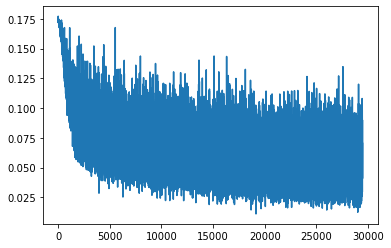

------
Subject:  8 Training Time 5750.187167644501 Best Test Acc:  0.774750830564784
test subjects:  ['./seg\\a09', './seg\\a18']
*********
33329 984
31907 984
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6678330302238464
Eval Loss:  0.6979125738143921
Eval Loss:  0.6788997650146484
[[19903    96]
 [11659   249]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     19999
           1       0.72      0.02      0.04     11908

    accuracy                           0.63     31907
   macro avg       0.68      0.51      0.41     31907
weighted avg       0.66      0.63      0.50     31907

acc:  0.631585545491585
pre:  0.7217391304347827

[[161   4]
 [619 200]]
              precision    recall  f1-score   support

           0       0.21      0.98      0.34       165
           1       0.98      0.24      0.39       819

    accuracy                           0.37       984
   macro avg       0.59      0.61      0.37       984
weighted avg       0.85      0.37      0.38       984

acc:  0.366869918699187
pre:  0.9803921568627451
rec:  0.2442002442002442
ma F1:  0.36587379168024325
mi F1:  0.36686991869918706
we F1:  0.3825780755363761
Loss:  0.0693397969007492
Loss:  0.0795348584651947
Loss:  0.051828376948833466
15 **********
epoch:  16
Loss:  0.05455678328871727
Loss:  0.08233578503131866
Loss:  0.1057010069489479
16 **********
epoch:  17
Loss:  0.10753563046455383
Loss:  0.09889133274555206
Loss:  0.06883988529443741
17 **********
epoch:  18
Eval Loss:  0.00409698486328125
Eval Loss:  0.023157358169555664
Eval Loss:  0.004034757614135742
[[19263   736]
 [ 2777  9131]]
              precision    recall  f1-score   su

[[153  12]
 [463 356]]
              precision    recall  f1-score   support

           0       0.25      0.93      0.39       165
           1       0.97      0.43      0.60       819

    accuracy                           0.52       984
   macro avg       0.61      0.68      0.50       984
weighted avg       0.85      0.52      0.56       984

acc:  0.5172764227642277
pre:  0.967391304347826
rec:  0.4346764346764347
ma F1:  0.4958184428621203
mi F1:  0.5172764227642277
we F1:  0.5649490776206337
Subject 9 Current Train Acc:  0.9164446673143825 Current Test Acc:  0.5172764227642277
Loss:  0.034010253846645355
Loss:  0.0519820973277092
Loss:  0.08139543235301971
33 **********
epoch:  34
Loss:  0.07472902536392212
Loss:  0.045469753444194794
Loss:  0.06966609507799149
34 **********
epoch:  35
Loss:  0.031166478991508484
Loss:  0.08083006739616394
Loss:  0.07290340214967728
35 **********
epoch:  36
Eval Loss:  0.0016453266143798828
Eval Loss:  0.011515378952026367
Eval Loss:  0.0016441

Loss:  0.05413363128900528
Loss:  0.04737109690904617
50 **********
epoch:  51
Eval Loss:  0.0016667842864990234
Eval Loss:  0.01122426986694336
Eval Loss:  0.001590728759765625
[[19186   813]
 [ 1781 10127]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     19999
           1       0.93      0.85      0.89     11908

    accuracy                           0.92     31907
   macro avg       0.92      0.90      0.91     31907
weighted avg       0.92      0.92      0.92     31907

acc:  0.9187012254364246
pre:  0.9256855575868373
rec:  0.8504366812227074
ma F1:  0.9115731421089649
mi F1:  0.9187012254364246
we F1:  0.9179395536557666
[[156   9]
 [489 330]]
              precision    recall  f1-score   support

           0       0.24      0.95      0.39       165
           1       0.97      0.40      0.57       819

    accuracy                           0.49       984
   macro avg       0.61      0.67      0.48       984
weighted avg 

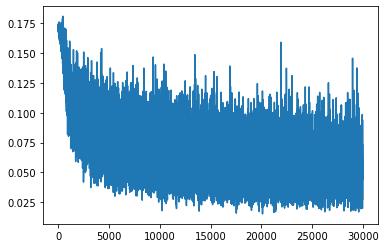

------
Subject:  9 Training Time 5791.822843074799 Best Test Acc:  0.5599593495934959
test subjects:  ['./seg\\a11']
*********
33847 466
32425 466
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6226849555969238
Eval Loss:  0.7825818061828613
Eval Loss:  0.6049126982688904
[[   16 19904]
 [   48 12457]]
              precision    recall  f1-score   support

           0       0.25      0.00      0.00     19920
           1       0.38      1.00      0.56     12505

    accuracy                           0.38     32425
   macro avg       0.32      0.50      0.28     32425
weighted avg       0.30      0.38      0.22     32425

acc:  0.3846723207401696
pre:  0.38493866073359906
rec:  0.99

[[218  26]
 [139  83]]
              precision    recall  f1-score   support

           0       0.61      0.89      0.73       244
           1       0.76      0.37      0.50       222

    accuracy                           0.65       466
   macro avg       0.69      0.63      0.61       466
weighted avg       0.68      0.65      0.62       466

acc:  0.6459227467811158
pre:  0.7614678899082569
rec:  0.3738738738738739
ma F1:  0.6134840723668006
mi F1:  0.6459227467811158
we F1:  0.6187703748639483
Loss:  0.05596291646361351
Loss:  0.08929218351840973
Loss:  0.0985250174999237
15 **********
epoch:  16
Loss:  0.08605203032493591
Loss:  0.06562570482492447
Loss:  0.05724967643618584
16 **********
epoch:  17
Loss:  0.07344672083854675
Loss:  0.04668257758021355
Loss:  0.07552367448806763
17 **********
epoch:  18
Eval Loss:  0.10963302850723267
Eval Loss:  0.0038328170776367188
Eval Loss:  2.003368854522705
[[19047   873]
 [ 2590  9915]]
              precision    recall  f1-score   supp

[[225  19]
 [156  66]]
              precision    recall  f1-score   support

           0       0.59      0.92      0.72       244
           1       0.78      0.30      0.43       222

    accuracy                           0.62       466
   macro avg       0.68      0.61      0.57       466
weighted avg       0.68      0.62      0.58       466

acc:  0.6244635193133047
pre:  0.7764705882352941
rec:  0.2972972972972973
ma F1:  0.5749837133550488
mi F1:  0.6244635193133047
we F1:  0.5818299758146818
Loss:  0.040975600481033325
Loss:  0.06981456279754639
Loss:  0.059003181755542755
33 **********
epoch:  34
Loss:  0.04610959812998772
Loss:  0.036597803235054016
Loss:  0.07967790216207504
34 **********
epoch:  35
Loss:  0.048131927847862244
Loss:  0.05030049756169319
Loss:  0.046463243663311005
35 **********
epoch:  36
Eval Loss:  0.08238101005554199
Eval Loss:  0.0016813278198242188
Eval Loss:  2.8022687435150146
[[18971   949]
 [ 1805 10700]]
              precision    recall  f1-score

[[226  18]
 [150  72]]
              precision    recall  f1-score   support

           0       0.60      0.93      0.73       244
           1       0.80      0.32      0.46       222

    accuracy                           0.64       466
   macro avg       0.70      0.63      0.60       466
weighted avg       0.70      0.64      0.60       466

acc:  0.6394849785407726
pre:  0.8
rec:  0.32432432432432434
ma F1:  0.5952853598014889
mi F1:  0.6394849785407726
we F1:  0.601599591049958
Loss:  0.025851719081401825
Loss:  0.046293750405311584
Loss:  0.045942556113004684
51 **********
epoch:  52
Loss:  0.05819883942604065
Loss:  0.04012175276875496
Loss:  0.05056732892990112
52 **********
epoch:  53
Loss:  0.050330743193626404
Loss:  0.05895489081740379
Loss:  0.061257414519786835
53 **********
epoch:  54
Eval Loss:  0.10503649711608887
Eval Loss:  0.0014934539794921875
Eval Loss:  1.9183416366577148
[[18884  1036]
 [ 1289 11216]]
              precision    recall  f1-score   support

   

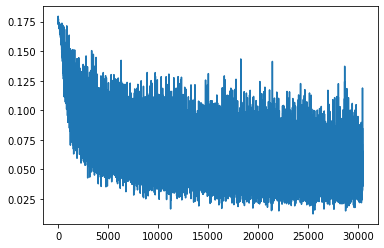

------
Subject:  10 Training Time 5824.007786273956 Best Test Acc:  0.6716738197424893
test subjects:  ['./seg\\a15', './seg\\x27', './seg\\x28']
*********
32810 1503
31397 1494
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6738974452018738
Eval Loss:  0.6561837792396545
Eval Loss:  0.7223235368728638
[[ 1731 18218]
 [ 1536  9912]]
              precision    recall  f1-score   support

           0       0.53      0.09      0.15     19949
           1       0.35      0.87      0.50     11448

    accuracy                           0.37     31397
   macro avg       0.44      0.48      0.33     31397
weighted avg       0.47      0.37      0.28     31397

acc:  0.37083160811542504
pre:

[[ 111  104]
 [ 217 1062]]
              precision    recall  f1-score   support

           0       0.34      0.52      0.41       215
           1       0.91      0.83      0.87      1279

    accuracy                           0.79      1494
   macro avg       0.62      0.67      0.64      1494
weighted avg       0.83      0.79      0.80      1494

acc:  0.785140562248996
pre:  0.9108061749571184
rec:  0.8303362001563722
ma F1:  0.6387757177236213
mi F1:  0.7851405622489959
we F1:  0.8025319685911279
Loss:  0.05795615166425705
Loss:  0.06351885944604874
Loss:  0.0652237981557846
15 **********
epoch:  16
Loss:  0.08910255134105682
Loss:  0.08267147839069366
Loss:  0.07798921316862106
16 **********
epoch:  17
Loss:  0.06023390591144562
Loss:  0.06672366708517075
Loss:  0.09407109767198563
17 **********
epoch:  18
Eval Loss:  0.03101193904876709
Eval Loss:  0.17230117321014404
Eval Loss:  0.010164499282836914
[[19163   786]
 [ 2726  8722]]
              precision    recall  f1-score   

[[121  94]
 [418 861]]
              precision    recall  f1-score   support

           0       0.22      0.56      0.32       215
           1       0.90      0.67      0.77      1279

    accuracy                           0.66      1494
   macro avg       0.56      0.62      0.55      1494
weighted avg       0.80      0.66      0.71      1494

acc:  0.6572958500669344
pre:  0.9015706806282723
rec:  0.673182173573104
ma F1:  0.5458847946731131
mi F1:  0.6572958500669344
we F1:  0.7060758256717967
Loss:  0.0874018520116806
Loss:  0.07559148222208023
Loss:  0.04703260585665703
33 **********
epoch:  34
Loss:  0.06538764387369156
Loss:  0.053849153220653534
Loss:  0.049087829887866974
34 **********
epoch:  35
Loss:  0.07858777046203613
Loss:  0.04460807144641876
Loss:  0.0720185860991478
35 **********
epoch:  36
Eval Loss:  0.014473438262939453
Eval Loss:  0.47731223702430725
Eval Loss:  0.009962081909179688
[[19252   697]
 [ 2392  9056]]
              precision    recall  f1-score   su

[[124  91]
 [533 746]]
              precision    recall  f1-score   support

           0       0.19      0.58      0.28       215
           1       0.89      0.58      0.71      1279

    accuracy                           0.58      1494
   macro avg       0.54      0.58      0.49      1494
weighted avg       0.79      0.58      0.64      1494

acc:  0.5823293172690763
pre:  0.8912783751493429
rec:  0.5832681782642689
ma F1:  0.49475381973951194
mi F1:  0.5823293172690763
we F1:  0.6445614232305994
Loss:  0.04487209767103195
Loss:  0.07793769985437393
Loss:  0.04713854566216469
51 **********
epoch:  52
Loss:  0.039512068033218384
Loss:  0.0852784737944603
Loss:  0.06409326195716858
52 **********
epoch:  53
Loss:  0.05522563308477402
Loss:  0.05346935614943504
Loss:  0.05369246378540993
53 **********
epoch:  54
Eval Loss:  0.009222269058227539
Eval Loss:  0.24771004915237427
Eval Loss:  0.011503219604492188
[[19337   612]
 [ 2034  9414]]
              precision    recall  f1-score   

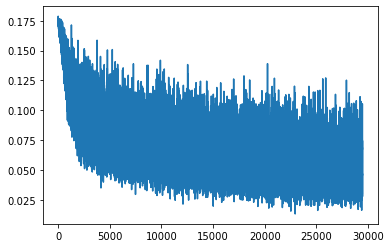

------
Subject:  11 Training Time 5819.479893922806 Best Test Acc:  0.8145917001338688
test subjects:  ['./seg\\a17', './seg\\x12']
*********
33301 1012
31880 1011
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8569623231887817
Eval Loss:  0.8455221652984619
Eval Loss:  0.5813891291618347
[[    0 19367]
 [    0 12513]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19367
           1       0.39      1.00      0.56     12513

    accuracy                           0.39     31880
   macro avg       0.20      0.50      0.28     31880
weighted avg       0.15      0.39      0.22     31880

acc:  0.39250313676286075
pre:  0.3925031367

[[777  20]
 [108 106]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       797
           1       0.84      0.50      0.62       214

    accuracy                           0.87      1011
   macro avg       0.86      0.74      0.77      1011
weighted avg       0.87      0.87      0.86      1011

acc:  0.8733926805143423
pre:  0.8412698412698413
rec:  0.4953271028037383
ma F1:  0.7737147653353851
mi F1:  0.8733926805143423
we F1:  0.8603201670482495
Subject 12 Current Train Acc:  0.8751882057716437 Current Test Acc:  0.8733926805143423
Loss:  0.06810156255960464
Loss:  0.05422763153910637
Loss:  0.08470087498426437
15 **********
epoch:  16
Loss:  0.06537051498889923
Loss:  0.045416153967380524
Loss:  0.07487471401691437
16 **********
epoch:  17
Loss:  0.07553337514400482
Loss:  0.09082544595003128
Loss:  0.0915982574224472
17 **********
epoch:  18
Eval Loss:  0.08614718914031982
Eval Loss:  0.008637666702270508
Eval Loss:  0.417821735

Eval Loss:  0.2076776623725891
[[18566   801]
 [ 2209 10304]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     19367
           1       0.93      0.82      0.87     12513

    accuracy                           0.91     31880
   macro avg       0.91      0.89      0.90     31880
weighted avg       0.91      0.91      0.90     31880

acc:  0.9055834378920954
pre:  0.9278703286807745
rec:  0.8234635978582274
ma F1:  0.8987855117888107
mi F1:  0.9055834378920954
we F1:  0.9044249435864279
[[737  60]
 [ 68 146]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       797
           1       0.71      0.68      0.70       214

    accuracy                           0.87      1011
   macro avg       0.81      0.80      0.81      1011
weighted avg       0.87      0.87      0.87      1011

acc:  0.8733926805143423
pre:  0.7087378640776699
rec:  0.6822429906542056
ma F1:  0.8076689851970751
mi 

Loss:  0.037976041436195374
Loss:  0.06389830261468887
Loss:  0.04482043907046318
48 **********
epoch:  49
Loss:  0.06438886374235153
Loss:  0.033090218901634216
Loss:  0.059394821524620056
49 **********
epoch:  50
Loss:  0.07138019055128098
Loss:  0.03927168622612953
Loss:  0.0944070890545845
50 **********
epoch:  51
Eval Loss:  0.02177739143371582
Eval Loss:  0.021825194358825684
Eval Loss:  0.19016969203948975
[[18496   871]
 [ 1751 10762]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     19367
           1       0.93      0.86      0.89     12513

    accuracy                           0.92     31880
   macro avg       0.92      0.91      0.91     31880
weighted avg       0.92      0.92      0.92     31880

acc:  0.9177540777917189
pre:  0.9251267944640248
rec:  0.8600655318468793
ma F1:  0.9126109322225273
mi F1:  0.9177540777917189
we F1:  0.917168873744539
[[745  52]
 [ 73 141]]
              precision    recall  f1-score   s

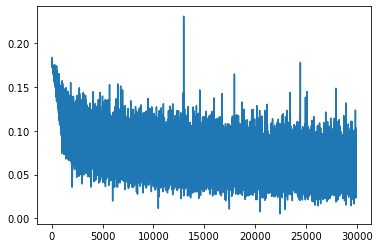

------
Subject:  12 Training Time 5823.405604839325 Best Test Acc:  0.8832838773491593
test subjects:  ['./seg\\a19', './seg\\x05', './seg\\x08', './seg\\x25']
*********
32279 2034
30857 2034
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.798627495765686
Eval Loss:  0.7970882654190063
Eval Loss:  0.7846294045448303
[[    0 19266]
 [    0 11591]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19266
           1       0.38      1.00      0.55     11591

    accuracy                           0.38     30857
   macro avg       0.19      0.50      0.27     30857
weighted avg       0.14      0.38      0.21     30857

acc:  0.375635998

[[711 187]
 [173 963]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       898
           1       0.84      0.85      0.84      1136

    accuracy                           0.82      2034
   macro avg       0.82      0.82      0.82      2034
weighted avg       0.82      0.82      0.82      2034

acc:  0.8230088495575221
pre:  0.837391304347826
rec:  0.8477112676056338
ma F1:  0.820249741509584
mi F1:  0.8230088495575222
we F1:  0.8228555657770812
Loss:  0.04874477535486221
Loss:  0.06494338810443878
Loss:  0.07237252593040466
15 **********
epoch:  16
Loss:  0.041194312274456024
Loss:  0.06281191855669022
Loss:  0.10241502523422241
16 **********
epoch:  17
Loss:  0.08360596001148224
Loss:  0.07939021289348602
Loss:  0.08838541060686111
17 **********
epoch:  18
Eval Loss:  0.00803685188293457
Eval Loss:  0.008223295211791992
Eval Loss:  0.14154183864593506
[[18600   666]
 [ 3147  8444]]
              precision    recall  f1-score   sup

Eval Loss:  0.004823446273803711
Eval Loss:  0.03623497486114502
[[18200  1066]
 [ 1898  9693]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     19266
           1       0.90      0.84      0.87     11591

    accuracy                           0.90     30857
   macro avg       0.90      0.89      0.90     30857
weighted avg       0.90      0.90      0.90     30857

acc:  0.9039439997407396
pre:  0.9009201598661586
rec:  0.8362522646881201
ma F1:  0.8960426622219464
mi F1:  0.9039439997407396
we F1:  0.9031712346278166
[[782 116]
 [265 871]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       898
           1       0.88      0.77      0.82      1136

    accuracy                           0.81      2034
   macro avg       0.81      0.82      0.81      2034
weighted avg       0.82      0.81      0.81      2034

acc:  0.8126843657817109
pre:  0.8824721377912867
rec:  0.7667253521126

Loss:  0.06164541095495224
Loss:  0.03895897418260574
Loss:  0.06325441598892212
48 **********
epoch:  49
Loss:  0.05567669868469238
Loss:  0.08651964366436005
Loss:  0.023141300305724144
49 **********
epoch:  50
Loss:  0.04531587287783623
Loss:  0.0613587349653244
Loss:  0.04639894887804985
50 **********
epoch:  51
Eval Loss:  0.002239227294921875
Eval Loss:  0.006242036819458008
Eval Loss:  0.015443801879882812
[[18361   905]
 [ 1534 10057]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     19266
           1       0.92      0.87      0.89     11591

    accuracy                           0.92     30857
   macro avg       0.92      0.91      0.91     30857
weighted avg       0.92      0.92      0.92     30857

acc:  0.9209579673979972
pre:  0.9174420726144864
rec:  0.8676559399534122
ma F1:  0.9147866954092277
mi F1:  0.9209579673979972
we F1:  0.9204905143535687
[[740 158]
 [212 924]]
              precision    recall  f1-score   

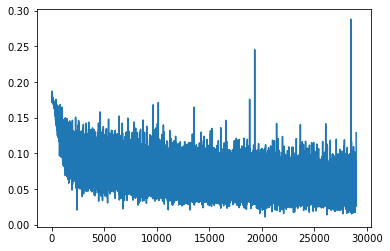

------
Subject:  13 Training Time 5734.7265067100525 Best Test Acc:  0.8549655850540806
test subjects:  ['./seg\\b01', './seg\\x03']
*********
33361 952
31939 952
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8272640705108643
Eval Loss:  0.7926221489906311
Eval Loss:  0.8202564716339111
[[    0 19243]
 [    0 12696]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19243
           1       0.40      1.00      0.57     12696

    accuracy                           0.40     31939
   macro avg       0.20      0.50      0.28     31939
weighted avg       0.16      0.40      0.23     31939

acc:  0.3975077491468111
pre:  0.397507749146

[[914   7]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       921
           1       0.00      0.00      0.00        31

    accuracy                           0.96       952
   macro avg       0.48      0.50      0.49       952
weighted avg       0.94      0.96      0.95       952

acc:  0.9600840336134454
pre:  0.0
rec:  0.0
ma F1:  0.48981779206859594
mi F1:  0.9600840336134454
we F1:  0.9477356859142371
Loss:  0.06006040796637535
Loss:  0.09360269457101822
Loss:  0.08171959966421127
15 **********
epoch:  16
Loss:  0.06575257331132889
Loss:  0.07003612071275711
Loss:  0.07695487141609192
16 **********
epoch:  17
Loss:  0.08210255205631256
Loss:  0.1133553683757782
Loss:  0.07414521276950836
17 **********
epoch:  18
Eval Loss:  0.015779972076416016
Eval Loss:  0.03323507308959961
Eval Loss:  0.009575366973876953
[[17923  1320]
 [ 2556 10140]]
              precision    recall  f1-score   support

           0       0.8

[[914   7]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       921
           1       0.00      0.00      0.00        31

    accuracy                           0.96       952
   macro avg       0.48      0.50      0.49       952
weighted avg       0.94      0.96      0.95       952

acc:  0.9600840336134454
pre:  0.0
rec:  0.0
ma F1:  0.48981779206859594
mi F1:  0.9600840336134454
we F1:  0.9477356859142371
Loss:  0.06974293291568756
Loss:  0.06739531457424164
Loss:  0.04666699096560478
33 **********
epoch:  34
Loss:  0.06846042722463608
Loss:  0.06529901176691055
Loss:  0.0630737766623497
34 **********
epoch:  35
Loss:  0.04005248472094536
Loss:  0.04690182954072952
Loss:  0.05757568031549454
35 **********
epoch:  36
Eval Loss:  0.03244125843048096
Eval Loss:  0.033170104026794434
Eval Loss:  0.041472434997558594
[[18181  1062]
 [ 2057 10639]]
              precision    recall  f1-score   support

           0       0.9

[[914   7]
 [ 31   0]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       921
           1       0.00      0.00      0.00        31

    accuracy                           0.96       952
   macro avg       0.48      0.50      0.49       952
weighted avg       0.94      0.96      0.95       952

acc:  0.9600840336134454
pre:  0.0
rec:  0.0
ma F1:  0.48981779206859594
mi F1:  0.9600840336134454
we F1:  0.9477356859142371
Loss:  0.05677051469683647
Loss:  0.03406853973865509
Loss:  0.041218411177396774
51 **********
epoch:  52
Loss:  0.04833154007792473
Loss:  0.06227772682905197
Loss:  0.0843675434589386
52 **********
epoch:  53
Loss:  0.07119690626859665
Loss:  0.04671226441860199
Loss:  0.06781791895627975
53 **********
epoch:  54
Eval Loss:  0.060117483139038086
Eval Loss:  0.04297327995300293
Eval Loss:  0.07543063163757324
[[17917  1326]
 [ 1289 11407]]
              precision    recall  f1-score   support

           0       0.9

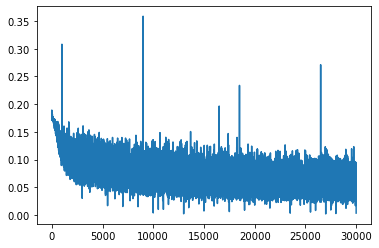

------
Subject:  14 Training Time 5814.32467675209 Best Test Acc:  0.9632352941176471
test subjects:  ['./seg\\b02', './seg\\b03', './seg\\x16', './seg\\x21']
*********
32330 1983
30908 1983
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.821864128112793
Eval Loss:  0.8026704788208008
Eval Loss:  0.6015551090240479
[[18532     0]
 [12376     0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     18532
           1       0.00      0.00      0.00     12376

    accuracy                           0.60     30908
   macro avg       0.30      0.50      0.37     30908
weighted avg       0.36      0.60      0.45     30908

acc:  0.5995858677

[[1608   24]
 [ 299   52]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1632
           1       0.68      0.15      0.24       351

    accuracy                           0.84      1983
   macro avg       0.76      0.57      0.58      1983
weighted avg       0.82      0.84      0.79      1983

acc:  0.8371154815935451
pre:  0.6842105263157895
rec:  0.14814814814814814
ma F1:  0.5761454994960802
mi F1:  0.8371154815935451
we F1:  0.7909928947832605
Subject 15 Current Train Acc:  0.8769574220266597 Current Test Acc:  0.8371154815935451
Loss:  0.08558283746242523
Loss:  0.09682188928127289
Loss:  0.06053856015205383
15 **********
epoch:  16
Loss:  0.09647662937641144
Loss:  0.06579550355672836
Loss:  0.051308032125234604
16 **********
epoch:  17
Loss:  0.08406215906143188
Loss:  0.055067919194698334
Loss:  0.08955351263284683
17 **********
epoch:  18
Eval Loss:  1.370928406715393
Eval Loss:  0.6774848103523254
Eval Loss:  0.009785

[[1474  158]
 [ 243  108]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1632
           1       0.41      0.31      0.35       351

    accuracy                           0.80      1983
   macro avg       0.63      0.61      0.62      1983
weighted avg       0.78      0.80      0.79      1983

acc:  0.7977811396873424
pre:  0.40601503759398494
rec:  0.3076923076923077
ma F1:  0.6151719011408132
mi F1:  0.7977811396873425
we F1:  0.7864181929256623
Loss:  0.03958167880773544
Loss:  0.06358294188976288
Loss:  0.05501016229391098
33 **********
epoch:  34
Loss:  0.05058477446436882
Loss:  0.05885345861315727
Loss:  0.060454413294792175
34 **********
epoch:  35
Loss:  0.06389914453029633
Loss:  0.026352841407060623
Loss:  0.049822255969047546
35 **********
epoch:  36
Eval Loss:  1.2857818603515625
Eval Loss:  0.15470701456069946
Eval Loss:  0.0073468685150146484
[[17005  1527]
 [ 1265 11111]]
              precision    recall  f1-sc

[[1405  227]
 [ 242  109]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1632
           1       0.32      0.31      0.32       351

    accuracy                           0.76      1983
   macro avg       0.59      0.59      0.59      1983
weighted avg       0.76      0.76      0.76      1983

acc:  0.7634896621280888
pre:  0.3244047619047619
rec:  0.31054131054131057
ma F1:  0.5871451382424346
mi F1:  0.7634896621280888
we F1:  0.7614486375460789
Loss:  0.05027206614613533
Loss:  0.030543137341737747
Loss:  0.03960505127906799
51 **********
epoch:  52
Loss:  0.06521883606910706
Loss:  0.019644442945718765
Loss:  0.03156251832842827
52 **********
epoch:  53
Loss:  0.060534678399562836
Loss:  0.041274294257164
Loss:  0.05228165164589882
53 **********
epoch:  54
Eval Loss:  1.0035953521728516
Eval Loss:  0.16195178031921387
Eval Loss:  0.0035490989685058594
[[17224  1308]
 [ 1157 11219]]
              precision    recall  f1-scor

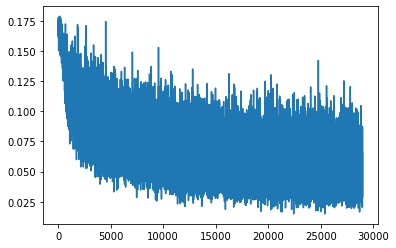

------
Subject:  15 Training Time 5975.5635578632355 Best Test Acc:  0.8371154815935451
test subjects:  ['./seg\\b04', './seg\\c08']
*********
33371 942
32061 830
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7757585048675537
Eval Loss:  0.7598429322242737
Eval Loss:  0.6669012308120728
[[   82 19262]
 [   32 12685]]
              precision    recall  f1-score   support

           0       0.72      0.00      0.01     19344
           1       0.40      1.00      0.57     12717

    accuracy                           0.40     32061
   macro avg       0.56      0.50      0.29     32061
weighted avg       0.59      0.40      0.23     32061

acc:  0.39820966283022985
pre:  0.39706388706

[[795  25]
 [  9   1]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       820
           1       0.04      0.10      0.06        10

    accuracy                           0.96       830
   macro avg       0.51      0.53      0.52       830
weighted avg       0.98      0.96      0.97       830

acc:  0.9590361445783132
pre:  0.038461538461538464
rec:  0.1
ma F1:  0.5173097974822113
mi F1:  0.9590361445783132
we F1:  0.9679374311696705
Loss:  0.05954712629318237
Loss:  0.05324253812432289
Loss:  0.09381464123725891
15 **********
epoch:  16
Loss:  0.06631499528884888
Loss:  0.051660649478435516
Loss:  0.08723731338977814
16 **********
epoch:  17
Loss:  0.08587897568941116
Loss:  0.05326174944639206
Loss:  0.06366615742444992
17 **********
epoch:  18
Eval Loss:  0.03792846202850342
Eval Loss:  0.016227006912231445
Eval Loss:  0.24830323457717896
[[18973   371]
 [ 5152  7565]]
              precision    recall  f1-score   support

     

[[788  32]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       820
           1       0.06      0.20      0.09        10

    accuracy                           0.95       830
   macro avg       0.52      0.58      0.53       830
weighted avg       0.98      0.95      0.96       830

acc:  0.9518072289156626
pre:  0.058823529411764705
rec:  0.2
ma F1:  0.533078307830783
mi F1:  0.9518072289156626
we F1:  0.9645928448266512
Loss:  0.03888043761253357
Loss:  0.05183129012584686
Loss:  0.04466358944773674
33 **********
epoch:  34
Loss:  0.07287293672561646
Loss:  0.11159880459308624
Loss:  0.08101827651262283
34 **********
epoch:  35
Loss:  0.0462479367852211
Loss:  0.10150180011987686
Loss:  0.06221785023808479
35 **********
epoch:  36
Eval Loss:  0.08861291408538818
Eval Loss:  0.06187403202056885
Eval Loss:  0.06169450283050537
[[18369   975]
 [ 2269 10448]]
              precision    recall  f1-score   support

         

[[773  47]
 [  8   2]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       820
           1       0.04      0.20      0.07        10

    accuracy                           0.93       830
   macro avg       0.52      0.57      0.52       830
weighted avg       0.98      0.93      0.95       830

acc:  0.9337349397590361
pre:  0.04081632653061224
rec:  0.2
ma F1:  0.5167215405625721
mi F1:  0.9337349397590361
we F1:  0.9548290027534098
Loss:  0.06667620688676834
Loss:  0.07243861258029938
Loss:  0.05110885947942734
51 **********
epoch:  52
Loss:  0.05225975811481476
Loss:  0.07578878104686737
Loss:  0.09607861936092377
52 **********
epoch:  53
Loss:  0.0833008736371994
Loss:  0.03768476843833923
Loss:  0.08993582427501678
53 **********
epoch:  54
Eval Loss:  0.34942418336868286
Eval Loss:  0.12974131107330322
Eval Loss:  0.05985891819000244
[[17946  1398]
 [ 1318 11399]]
              precision    recall  f1-score   support

         

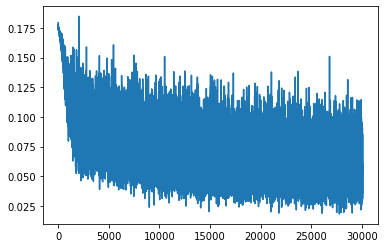

------
Subject:  16 Training Time 5866.856218338013 Best Test Acc:  0.9746987951807229
test subjects:  ['./seg\\b05', './seg\\x11']
*********
33423 890
32001 890
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6336763501167297
Eval Loss:  0.7320131659507751
Eval Loss:  0.6230421662330627
[[19322    22]
 [12644    13]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19344
           1       0.37      0.00      0.00     12657

    accuracy                           0.60     32001
   macro avg       0.49      0.50      0.38     32001
weighted avg       0.51      0.60      0.46     32001

acc:  0.6041998687541015
pre:  0.3714285714285

[[798  22]
 [ 63   7]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       820
           1       0.24      0.10      0.14        70

    accuracy                           0.90       890
   macro avg       0.58      0.54      0.55       890
weighted avg       0.87      0.90      0.89       890

acc:  0.9044943820224719
pre:  0.2413793103448276
rec:  0.1
ma F1:  0.545424500808201
mi F1:  0.9044943820224719
we F1:  0.8858826688369029
Loss:  0.06781947612762451
Loss:  0.06758543848991394
Loss:  0.046368975192308426
15 **********
epoch:  16
Loss:  0.08285465091466904
Loss:  0.07213427126407623
Loss:  0.07136312127113342
16 **********
epoch:  17
Loss:  0.06942738592624664
Loss:  0.07002362608909607
Loss:  0.10682383924722672
17 **********
epoch:  18
Eval Loss:  0.08161675930023193
Eval Loss:  0.6647317409515381
Eval Loss:  1.3273371458053589
[[18372   972]
 [ 2753  9904]]
              precision    recall  f1-score   support

           

[[534 286]
 [ 32  38]]
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       820
           1       0.12      0.54      0.19        70

    accuracy                           0.64       890
   macro avg       0.53      0.60      0.48       890
weighted avg       0.88      0.64      0.73       890

acc:  0.6426966292134831
pre:  0.11728395061728394
rec:  0.5428571428571428
ma F1:  0.48172808578899945
mi F1:  0.6426966292134831
we F1:  0.7251281010477951
Loss:  0.054587554186582565
Loss:  0.03413230553269386
Loss:  0.07342574000358582
33 **********
epoch:  34
Loss:  0.06161493808031082
Loss:  0.049201127141714096
Loss:  0.03399854525923729
34 **********
epoch:  35
Loss:  0.045396141707897186
Loss:  0.058031804859638214
Loss:  0.05253809317946434
35 **********
epoch:  36
Eval Loss:  0.11248040199279785
Eval Loss:  0.7880911231040955
Eval Loss:  1.8067102432250977
[[17652  1692]
 [ 1254 11403]]
              precision    recall  f1-score  

[[597 223]
 [ 38  32]]
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       820
           1       0.13      0.46      0.20        70

    accuracy                           0.71       890
   macro avg       0.53      0.59      0.51       890
weighted avg       0.88      0.71      0.77       890

acc:  0.7067415730337079
pre:  0.12549019607843137
rec:  0.45714285714285713
ma F1:  0.5087708168120539
mi F1:  0.7067415730337079
we F1:  0.7715638560443379
Loss:  0.0516105517745018
Loss:  0.038525957614183426
Loss:  0.07686153799295425
51 **********
epoch:  52
Loss:  0.08573339134454727
Loss:  0.08285203576087952
Loss:  0.06468618661165237
52 **********
epoch:  53
Loss:  0.07402446120977402
Loss:  0.05825052782893181
Loss:  0.08802828192710876
53 **********
epoch:  54
Eval Loss:  0.053490519523620605
Eval Loss:  0.33677345514297485
Eval Loss:  1.683439016342163
[[17808  1536]
 [ 1210 11447]]
              precision    recall  f1-score   su

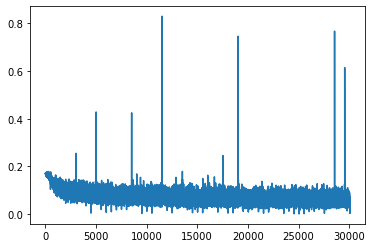

------
Subject:  17 Training Time 5844.705446004868 Best Test Acc:  0.9168539325842696
test subjects:  ['./seg\\c01', './seg\\x35']
*********
33346 967
31939 952
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7355660200119019
Eval Loss:  0.634566068649292
Eval Loss:  0.6638168096542358
[[19202    10]
 [12723     4]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19212
           1       0.29      0.00      0.00     12727

    accuracy                           0.60     31939
   macro avg       0.44      0.50      0.38     31939
weighted avg       0.48      0.60      0.45     31939

acc:  0.6013337925420332
pre:  0.28571428571428

D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss:  0.16677722334861755
Loss:  0.17237958312034607
Loss:  0.16759829223155975
0 **********
epoch:  1
Loss:  0.13935616612434387
Loss:  0.14670611917972565
Loss:  0.13222847878932953
1 **********
epoch:  2
Loss:  0.11412359029054642
Loss:  0.09980547428131104
Loss:  0.08653584122657776
2 **********
epoch:  3
Eval Loss:  0.33769792318344116
Eval Loss:  0.08522462844848633
Eval Loss:  0.03223252296447754
[[17600  1612]
 [ 3995  8732]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.86     19212
           1       0.84      0.69      0.76     12727

    accuracy                           0.82     31939
   macro avg       0.83      0.80      0.81     31939
weighted avg       0.83      0.82      0.82     31939

acc:  0.8244466013337926
pre:  0.8441608662026295
rec:  0.6861004164374951
ma F1:  0.8097823625638514
mi F1:  0.8244466013337927
we F1:  0.8205060419079052
[[911  41]
 [  0   0]]
              precision    recall  f1-score   support



D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss:  0.12253939360380173
Loss:  0.1003619134426117
Loss:  0.07905679941177368
3 **********
epoch:  4
Loss:  0.09082452207803726
Loss:  0.10514496266841888
Loss:  0.07900265604257584
4 **********
epoch:  5
Loss:  0.11785859614610672
Loss:  0.09176720678806305
Loss:  0.08964744955301285
5 **********
epoch:  6
Eval Loss:  0.14091801643371582
Eval Loss:  0.062279582023620605
Eval Loss:  0.01519918441772461
[[18422   790]
 [ 4563  8164]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     19212
           1       0.91      0.64      0.75     12727

    accuracy                           0.83     31939
   macro avg       0.86      0.80      0.81     31939
weighted avg       0.85      0.83      0.83     31939

acc:  0.8323992610914556
pre:  0.911771275407639
rec:  0.6414708886618999
ma F1:  0.813122217334878
mi F1:  0.8323992610914556
we F1:  0.825308962193662
[[932  20]
 [  0   0]]
              precision    recall  f1-score   support

   

Loss:  0.08045824617147446
Loss:  0.08225901424884796
Loss:  0.07967841625213623
21 **********
epoch:  22
Loss:  0.07084834575653076
Loss:  0.07488203793764114
Loss:  0.09528769552707672
22 **********
epoch:  23
Loss:  0.032845936715602875
Loss:  0.09701402485370636
Loss:  0.05349888652563095
23 **********
epoch:  24
Eval Loss:  0.0525357723236084
Eval Loss:  0.07801187038421631
Eval Loss:  0.0058879852294921875
[[18307   905]
 [ 2823  9904]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19212
           1       0.92      0.78      0.84     12727

    accuracy                           0.88     31939
   macro avg       0.89      0.87      0.87     31939
weighted avg       0.89      0.88      0.88     31939

acc:  0.8832774977300479
pre:  0.9162734758071978
rec:  0.7781881040308006
ma F1:  0.8745972276937015
mi F1:  0.8832774977300479
we F1:  0.8812962103410543
[[907  45]
 [  0   0]]
              precision    recall  f1-score   s

Loss:  0.04629984498023987
Loss:  0.05657699331641197
Loss:  0.07011173665523529
39 **********
epoch:  40
Loss:  0.07196319103240967
Loss:  0.08762875199317932
Loss:  0.08157500624656677
40 **********
epoch:  41
Loss:  0.049443379044532776
Loss:  0.07055402547121048
Loss:  0.07967237383127213
41 **********
epoch:  42
Eval Loss:  0.023072242736816406
Eval Loss:  0.05282783508300781
Eval Loss:  0.004251718521118164
[[17391  1821]
 [ 1186 11541]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     19212
           1       0.86      0.91      0.88     12727

    accuracy                           0.91     31939
   macro avg       0.90      0.91      0.90     31939
weighted avg       0.91      0.91      0.91     31939

acc:  0.9058517799555402
pre:  0.8637180062864841
rec:  0.9068122888347607
ma F1:  0.9025836372377247
mi F1:  0.9058517799555402
we F1:  0.9062065270710641
[[854  98]
 [  0   0]]
              precision    recall  f1-score   

Loss:  0.06991968303918839
Loss:  0.07975080609321594
Loss:  0.0653209537267685
57 **********
epoch:  58
Loss:  0.06997038424015045
Loss:  0.061637990176677704
Loss:  0.05038584768772125
58 **********
epoch:  59
Loss:  0.05981709063053131
Loss:  0.057947032153606415
Loss:  0.07501766830682755
59 **********


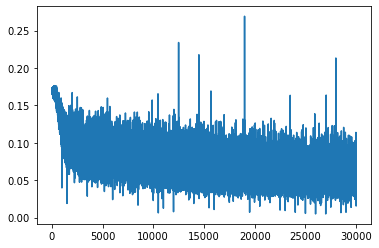

------
Subject:  18 Training Time 5841.481066226959 Best Test Acc:  1.0
test subjects:  ['./seg\\c02', './seg\\c09']
*********
33343 970
31940 951
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7838558554649353
Eval Loss:  0.8263049721717834
Eval Loss:  0.614149272441864
[[    0 19216]
 [    0 12724]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19216
           1       0.40      1.00      0.57     12724

    accuracy                           0.40     31940
   macro avg       0.20      0.50      0.28     31940
weighted avg       0.16      0.40      0.23     31940

acc:  0.3983719474013776
pre:  0.3983719474013776
rec:  1.0
ma

[[938  10]
 [  2   1]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       948
           1       0.09      0.33      0.14         3

    accuracy                           0.99       951
   macro avg       0.54      0.66      0.57       951
weighted avg       1.00      0.99      0.99       951

acc:  0.9873817034700315
pre:  0.09090909090909091
rec:  0.3333333333333333
ma F1:  0.5682506053268765
mi F1:  0.9873817034700315
we F1:  0.9909601973709337
Subject 19 Current Train Acc:  0.843143393863494 Current Test Acc:  0.9873817034700315
Loss:  0.07040530443191528
Loss:  0.057943571358919144
Loss:  0.09253980219364166
15 **********
epoch:  16
Loss:  0.08071311563253403
Loss:  0.09595206379890442
Loss:  0.0767446905374527
16 **********
epoch:  17
Loss:  0.06030265614390373
Loss:  0.09086012095212936
Loss:  0.06168016791343689
17 **********
epoch:  18
Eval Loss:  0.01474905014038086
Eval Loss:  0.008323907852172852
Eval Loss:  0.028719902

[[873  75]
 [  1   2]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       948
           1       0.03      0.67      0.05         3

    accuracy                           0.92       951
   macro avg       0.51      0.79      0.50       951
weighted avg       1.00      0.92      0.96       951

acc:  0.9200841219768665
pre:  0.025974025974025976
rec:  0.6666666666666666
ma F1:  0.5041437980241493
mi F1:  0.9200841219768665
we F1:  0.9554223354929412
Loss:  0.05691468343138695
Loss:  0.07200554013252258
Loss:  0.08232395350933075
33 **********
epoch:  34
Loss:  0.07206002622842789
Loss:  0.0658772811293602
Loss:  0.08741755783557892
34 **********
epoch:  35
Loss:  0.08031268417835236
Loss:  0.06321095675230026
Loss:  0.08030157536268234
35 **********
epoch:  36
Eval Loss:  0.008317232131958008
Eval Loss:  0.0065653324127197266
Eval Loss:  0.04749870300292969
[[18491   725]
 [ 2540 10184]]
              precision    recall  f1-score  

[[858  90]
 [  1   2]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       948
           1       0.02      0.67      0.04         3

    accuracy                           0.90       951
   macro avg       0.51      0.79      0.50       951
weighted avg       1.00      0.90      0.95       951

acc:  0.9043112513144059
pre:  0.021739130434782608
rec:  0.6666666666666666
ma F1:  0.49587277546383945
mi F1:  0.9043112513144059
we F1:  0.9467774012568129
Loss:  0.06855130940675735
Loss:  0.08035430312156677
Loss:  0.04991302639245987
51 **********
epoch:  52
Loss:  0.059546951204538345
Loss:  0.04954046756029129
Loss:  0.041586391627788544
52 **********
epoch:  53
Loss:  0.08206973224878311
Loss:  0.08527719974517822
Loss:  0.054473958909511566
53 **********
epoch:  54
Eval Loss:  0.005179166793823242
Eval Loss:  0.018643617630004883
Eval Loss:  0.026093006134033203
[[17812  1404]
 [ 1179 11545]]
              precision    recall  f1-sc

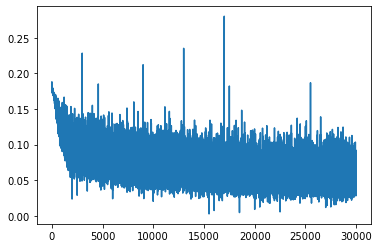

------
Subject:  19 Training Time 5860.26583981514 Best Test Acc:  0.9873817034700315
test subjects:  ['./seg\\c03', './seg\\x04']
*********
33377 936
31961 930
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.595427393913269
Eval Loss:  0.7862551808357239
Eval Loss:  0.7953088283538818
[[19234     0]
 [12727     0]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19234
           1       0.00      0.00      0.00     12727

    accuracy                           0.60     31961
   macro avg       0.30      0.50      0.38     31961
weighted avg       0.36      0.60      0.45     31961

acc:  0.601795938800413
pre:  0.0
rec:  0.0
ma F

Loss:  0.06863687187433243
Loss:  0.07755646109580994
Loss:  0.08363353461027145
15 **********
epoch:  16
Loss:  0.07214989513158798
Loss:  0.07226290553808212
Loss:  0.051597025245428085
16 **********
epoch:  17
Loss:  0.05673450976610184
Loss:  0.08856700360774994
Loss:  0.07227206230163574
17 **********
epoch:  18
Eval Loss:  0.03103458881378174
Eval Loss:  0.3493017256259918
Eval Loss:  1.363337516784668
[[18555   679]
 [ 3270  9457]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     19234
           1       0.93      0.74      0.83     12727

    accuracy                           0.88     31961
   macro avg       0.89      0.85      0.87     31961
weighted avg       0.88      0.88      0.87     31961

acc:  0.8764431651074748
pre:  0.9330110497237569
rec:  0.7430659228412038
ma F1:  0.8655484204656057
mi F1:  0.8764431651074748
we F1:  0.8733404740361314
[[910  20]
 [  0   0]]
              precision    recall  f1-score   suppo

Loss:  0.05625632032752037
Loss:  0.0611887127161026
Loss:  0.0525619201362133
33 **********
epoch:  34
Loss:  0.06387629359960556
Loss:  0.04987413436174393
Loss:  0.06635968387126923
34 **********
epoch:  35
Loss:  0.06522276997566223
Loss:  0.08752801269292831
Loss:  0.05280778184533119
35 **********
epoch:  36
Eval Loss:  0.04646444320678711
Eval Loss:  0.2745774984359741
Eval Loss:  1.152712106704712
[[18429   805]
 [ 2283 10444]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     19234
           1       0.93      0.82      0.87     12727

    accuracy                           0.90     31961
   macro avg       0.91      0.89      0.90     31961
weighted avg       0.91      0.90      0.90     31961

acc:  0.9033822471136698
pre:  0.9284380833851898
rec:  0.8206175846625284
ma F1:  0.8969500884920034
mi F1:  0.9033822471136698
we F1:  0.902191673482759
[[891  39]
 [  0   0]]
              precision    recall  f1-score   support



Loss:  0.09582047164440155
Loss:  0.05974183976650238
Loss:  0.056277744472026825
51 **********
epoch:  52
Loss:  0.08183619379997253
Loss:  0.07865113019943237
Loss:  0.06682921946048737
52 **********
epoch:  53
Loss:  0.04234650731086731
Loss:  0.05061442032456398
Loss:  0.053077373653650284
53 **********
epoch:  54
Eval Loss:  0.019926071166992188
Eval Loss:  0.2860338091850281
Eval Loss:  1.0662022829055786
[[18193  1041]
 [ 1662 11065]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     19234
           1       0.91      0.87      0.89     12727

    accuracy                           0.92     31961
   macro avg       0.92      0.91      0.91     31961
weighted avg       0.92      0.92      0.92     31961

acc:  0.9154281780920497
pre:  0.9140095820254419
rec:  0.8694114873890155
ma F1:  0.9110015063328656
mi F1:  0.9154281780920497
we F1:  0.9150425210827269
[[863  67]
 [  0   0]]
              precision    recall  f1-score   su

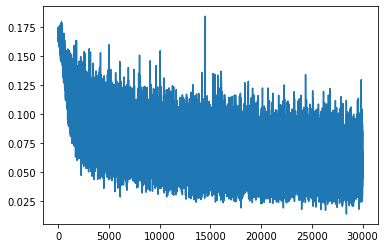

------
Subject:  20 Training Time 5810.995578527451 Best Test Acc:  1.0
test subjects:  ['./seg\\c04', './seg\\x29']
*********
33361 952
31959 932
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6928166747093201
Eval Loss:  0.7127252221107483
Eval Loss:  0.6976088881492615
[[ 7704 11528]
 [ 6084  6643]]
              precision    recall  f1-score   support

           0       0.56      0.40      0.47     19232
           1       0.37      0.52      0.43     12727

    accuracy                           0.45     31959
   macro avg       0.46      0.46      0.45     31959
weighted avg       0.48      0.45      0.45     31959

acc:  0.4489189273757001
pre:  0.3655825216003522
rec:  0.521

[[921  11]
 [  0   0]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       932
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       932
   macro avg       0.50      0.49      0.50       932
weighted avg       1.00      0.99      0.99       932

acc:  0.9881974248927039
pre:  0.0
rec:  0.0
ma F1:  0.4970318402590394
mi F1:  0.9881974248927039
we F1:  0.9940636805180788
Loss:  0.07059888541698456
Loss:  0.07333937287330627
Loss:  0.05939383804798126
15 **********
epoch:  16
Loss:  0.0637911856174469
Loss:  0.07166949659585953
Loss:  0.07231830060482025
16 **********
epoch:  17
Loss:  0.0654979720711708
Loss:  0.08974166214466095
Loss:  0.06741761416196823
17 **********
epoch:  18
Eval Loss:  0.039354920387268066
Eval Loss:  0.011485576629638672
Eval Loss:  2.0334367752075195
[[17880  1352]
 [ 2106 10621]]
              precision    recall  f1-score   support

           0       0.89  

[[918  14]
 [  0   0]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       932
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98       932
   macro avg       0.50      0.49      0.50       932
weighted avg       1.00      0.98      0.99       932

acc:  0.9849785407725322
pre:  0.0
rec:  0.0
ma F1:  0.4962162162162162
mi F1:  0.9849785407725322
we F1:  0.9924324324324325
Loss:  0.07454178482294083
Loss:  0.06124488264322281
Loss:  0.06642250716686249
33 **********
epoch:  34
Loss:  0.058939605951309204
Loss:  0.06724361330270767
Loss:  0.05028268322348595
34 **********
epoch:  35
Loss:  0.05632457882165909
Loss:  0.048179034143686295
Loss:  0.08201959729194641
35 **********
epoch:  36
Eval Loss:  0.05855357646942139
Eval Loss:  0.004940509796142578
Eval Loss:  1.8599965572357178
[[18431   801]
 [ 2267 10460]]
              precision    recall  f1-score   support

           0       0.8

[[927   5]
 [  0   0]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       932
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       932
   macro avg       0.50      0.50      0.50       932
weighted avg       1.00      0.99      1.00       932

acc:  0.9946351931330472
pre:  0.0
rec:  0.0
ma F1:  0.4986551909628833
mi F1:  0.9946351931330472
we F1:  0.9973103819257667
Loss:  0.08108130842447281
Loss:  0.05163799971342087
Loss:  0.07457894086837769
51 **********
epoch:  52
Loss:  0.05094803497195244
Loss:  0.060640521347522736
Loss:  0.07581336051225662
52 **********
epoch:  53
Loss:  0.063232421875
Loss:  0.03907988592982292
Loss:  0.07563742995262146
53 **********
epoch:  54
Eval Loss:  0.043320536613464355
Eval Loss:  0.002948760986328125
Eval Loss:  0.6540194153785706
[[18249   983]
 [ 1570 11157]]
              precision    recall  f1-score   support

           0       0.92    

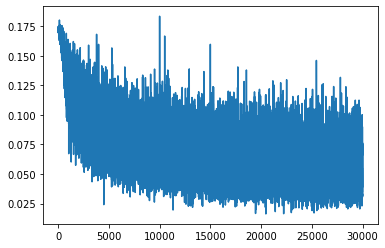

------
Subject:  21 Training Time 5824.757781505585 Best Test Acc:  0.9978540772532188
test subjects:  ['./seg\\c05', './seg\\x33']
*********
33374 939
32152 739
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6179713010787964
Eval Loss:  0.6338748335838318
Eval Loss:  0.7218332290649414
[[19425     4]
 [12722     1]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19429
           1       0.20      0.00      0.00     12723

    accuracy                           0.60     32152
   macro avg       0.40      0.50      0.38     32152
weighted avg       0.44      0.60      0.46     32152

acc:  0.604192585220204
pre:  0.2
rec:  7.8597

[[724  11]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       735
           1       0.00      0.00      0.00         4

    accuracy                           0.98       739
   macro avg       0.50      0.49      0.49       739
weighted avg       0.99      0.98      0.98       739

acc:  0.979702300405954
pre:  0.0
rec:  0.0
ma F1:  0.4948735475051264
mi F1:  0.979702300405954
we F1:  0.9843898712212935
Loss:  0.06391201168298721
Loss:  0.06682774424552917
Loss:  0.0705312043428421
15 **********
epoch:  16
Loss:  0.04712696000933647
Loss:  0.08598832786083221
Loss:  0.08180921524763107
16 **********
epoch:  17
Loss:  0.09033991396427155
Loss:  0.07654152065515518
Loss:  0.07239016890525818
17 **********
epoch:  18
Eval Loss:  0.0047948360443115234
Eval Loss:  0.012161016464233398
Eval Loss:  0.020040154457092285
[[18861   568]
 [ 3695  9028]]
              precision    recall  f1-score   support

           0       0.84

[[727   8]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       735
           1       0.00      0.00      0.00         4

    accuracy                           0.98       739
   macro avg       0.50      0.49      0.50       739
weighted avg       0.99      0.98      0.99       739

acc:  0.9837618403247632
pre:  0.0
rec:  0.0
ma F1:  0.49590723055934516
mi F1:  0.9837618403247631
we F1:  0.9864460472560722
Loss:  0.06601641327142715
Loss:  0.049969080835580826
Loss:  0.0670880675315857
33 **********
epoch:  34
Loss:  0.04340530186891556
Loss:  0.05389165133237839
Loss:  0.03652547672390938
34 **********
epoch:  35
Loss:  0.04215048998594284
Loss:  0.04228179529309273
Loss:  0.06745704263448715
35 **********
epoch:  36
Eval Loss:  0.004069805145263672
Eval Loss:  0.031154751777648926
Eval Loss:  0.00931692123413086
[[17871  1558]
 [ 1385 11338]]
              precision    recall  f1-score   support

           0       0.

[[729   6]
 [  4   0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       735
           1       0.00      0.00      0.00         4

    accuracy                           0.99       739
   macro avg       0.50      0.50      0.50       739
weighted avg       0.99      0.99      0.99       739

acc:  0.986468200270636
pre:  0.0
rec:  0.0
ma F1:  0.4965940054495913
mi F1:  0.986468200270636
we F1:  0.9878121623963453
Loss:  0.08668491989374161
Loss:  0.03711199015378952
Loss:  0.0707501620054245
51 **********
epoch:  52
Loss:  0.07542390376329422
Loss:  0.09300819784402847
Loss:  0.04317593574523926
52 **********
epoch:  53
Loss:  0.05161444470286369
Loss:  0.05826534330844879
Loss:  0.04730645939707756
53 **********
epoch:  54
Eval Loss:  0.004547119140625
Eval Loss:  0.0366663932800293
Eval Loss:  0.006323099136352539
[[18218  1211]
 [ 1379 11344]]
              precision    recall  f1-score   support

           0       0.93      

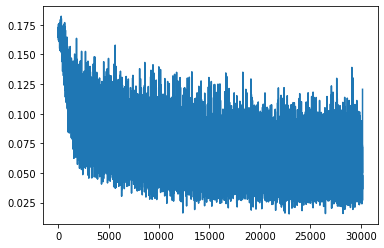

------
Subject:  22 Training Time 5849.645237207413 Best Test Acc:  0.9945872801082544
test subjects:  ['./seg\\c06']
*********
33845 468
32423 468
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7468750476837158
Eval Loss:  0.630771815776825
Eval Loss:  0.6436210870742798
[[19694     3]
 [12725     1]]
              precision    recall  f1-score   support

           0       0.61      1.00      0.76     19697
           1       0.25      0.00      0.00     12726

    accuracy                           0.61     32423
   macro avg       0.43      0.50      0.38     32423
weighted avg       0.47      0.61      0.46     32423

acc:  0.6074391635567344
pre:  0.25
rec:  7.857928650007858e-

Loss:  0.07913488149642944
Loss:  0.06977681070566177
Loss:  0.07395441830158234
15 **********
epoch:  16
Loss:  0.08688519150018692
Loss:  0.07464957237243652
Loss:  0.08427150547504425
16 **********
epoch:  17
Loss:  0.06708956509828568
Loss:  0.07986661046743393
Loss:  0.08787669241428375
17 **********
epoch:  18
Eval Loss:  0.6586238741874695
Eval Loss:  0.015418767929077148
Eval Loss:  0.005075931549072266
[[18973   724]
 [ 3437  9289]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     19697
           1       0.93      0.73      0.82     12726

    accuracy                           0.87     32423
   macro avg       0.89      0.85      0.86     32423
weighted avg       0.88      0.87      0.87     32423

acc:  0.8716651759553403
pre:  0.9276939978028563
rec:  0.72992299229923
ma F1:  0.8590953744667333
mi F1:  0.8716651759553403
we F1:  0.8681437105031935
[[465   2]
 [  1   0]]
              precision    recall  f1-score   supp

Loss:  0.041967637836933136
Loss:  0.056215256452560425
Loss:  0.08471104502677917
33 **********
epoch:  34
Loss:  0.06952866911888123
Loss:  0.04727686941623688
Loss:  0.06495624035596848
34 **********
epoch:  35
Loss:  0.08378928899765015
Loss:  0.037209536880254745
Loss:  0.06974825263023376
35 **********
epoch:  36
Eval Loss:  0.8957897424697876
Eval Loss:  0.038980841636657715
Eval Loss:  0.0019562244415283203
[[18530  1167]
 [ 1905 10821]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     19697
           1       0.90      0.85      0.88     12726

    accuracy                           0.91     32423
   macro avg       0.90      0.90      0.90     32423
weighted avg       0.91      0.91      0.90     32423

acc:  0.9052524442525368
pre:  0.9026526526526526
rec:  0.8503064592173503
ma F1:  0.8995752956733433
mi F1:  0.9052524442525369
we F1:  0.9047089579830537
[[466   1]
 [  1   0]]
              precision    recall  f1-score 

Loss:  0.06113559380173683
Loss:  0.07548842579126358
Loss:  0.08613681048154831
51 **********
epoch:  52
Loss:  0.04323119670152664
Loss:  0.050237759947776794
Loss:  0.04733185097575188
52 **********
epoch:  53
Loss:  0.03403382748365402
Loss:  0.07205779105424881
Loss:  0.05832820385694504
53 **********
epoch:  54
Eval Loss:  0.5209461450576782
Eval Loss:  0.04479658603668213
Eval Loss:  0.0012745857238769531
[[18667  1030]
 [ 1653 11073]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     19697
           1       0.91      0.87      0.89     12726

    accuracy                           0.92     32423
   macro avg       0.92      0.91      0.91     32423
weighted avg       0.92      0.92      0.92     32423

acc:  0.9172501002374858
pre:  0.9148971329422457
rec:  0.8701084394153701
ma F1:  0.912447185176877
mi F1:  0.9172501002374858
we F1:  0.9168560765236643
[[466   1]
 [  1   0]]
              precision    recall  f1-score   su

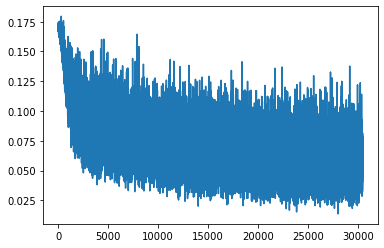

------
Subject:  23 Training Time 5875.03933930397 Best Test Acc:  0.9978632478632479
test subjects:  ['./seg\\c07', './seg\\x34']
*********
33409 904
32303 588
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8737848401069641
Eval Loss:  0.5588791966438293
Eval Loss:  0.5713838338851929
[[19578     0]
 [12725     0]]
              precision    recall  f1-score   support

           0       0.61      1.00      0.75     19578
           1       0.00      0.00      0.00     12725

    accuracy                           0.61     32303
   macro avg       0.30      0.50      0.38     32303
weighted avg       0.37      0.61      0.46     32303

acc:  0.6060737392811814
pre:  0.0
rec:  0.0
ma

[[572  14]
 [  1   1]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       586
           1       0.07      0.50      0.12         2

    accuracy                           0.97       588
   macro avg       0.53      0.74      0.55       588
weighted avg       1.00      0.97      0.98       588

acc:  0.9744897959183674
pre:  0.06666666666666667
rec:  0.5
ma F1:  0.5523524336395472
mi F1:  0.9744897959183674
we F1:  0.9841006290350479
Loss:  0.0755578801035881
Loss:  0.07162223011255264
Loss:  0.07034604996442795
15 **********
epoch:  16
Loss:  0.07450710237026215
Loss:  0.0983864814043045
Loss:  0.07681591063737869
16 **********
epoch:  17
Loss:  0.05798587575554848
Loss:  0.06320494413375854
Loss:  0.0736866220831871
17 **********
epoch:  18
Eval Loss:  0.04550802707672119
Eval Loss:  0.006439208984375
Eval Loss:  0.046032071113586426
[[19070   508]
 [ 4100  8625]]
              precision    recall  f1-score   support

           0

[[561  25]
 [  2   0]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       586
           1       0.00      0.00      0.00         2

    accuracy                           0.95       588
   macro avg       0.50      0.48      0.49       588
weighted avg       0.99      0.95      0.97       588

acc:  0.9540816326530612
pre:  0.0
rec:  0.0
ma F1:  0.48825065274151436
mi F1:  0.9540816326530612
we F1:  0.9731798724711817
Loss:  0.0509776696562767
Loss:  0.055700816214084625
Loss:  0.06801546365022659
33 **********
epoch:  34
Loss:  0.03182016313076019
Loss:  0.09394167363643646
Loss:  0.060670845210552216
34 **********
epoch:  35
Loss:  0.05108572542667389
Loss:  0.06112341955304146
Loss:  0.036058396100997925
35 **********
epoch:  36
Eval Loss:  0.016246318817138672
Eval Loss:  0.003046751022338867
Eval Loss:  0.07839381694793701
[[18448  1130]
 [ 1867 10858]]
              precision    recall  f1-score   support

           0       

[[557  29]
 [  2   0]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       586
           1       0.00      0.00      0.00         2

    accuracy                           0.95       588
   macro avg       0.50      0.48      0.49       588
weighted avg       0.99      0.95      0.97       588

acc:  0.9472789115646258
pre:  0.0
rec:  0.0
ma F1:  0.48646288209606986
mi F1:  0.9472789115646257
we F1:  0.9696164928853638
Loss:  0.05590822547674179
Loss:  0.08574281632900238
Loss:  0.055508192628622055
51 **********
epoch:  52
Loss:  0.05268396437168121
Loss:  0.04257363826036453
Loss:  0.039674270898103714
52 **********
epoch:  53
Loss:  0.06796037405729294
Loss:  0.028266912326216698
Loss:  0.054259758442640305
53 **********
epoch:  54
Eval Loss:  0.009287357330322266
Eval Loss:  0.0024933815002441406
Eval Loss:  0.03462481498718262
[[17808  1770]
 [ 1016 11709]]
              precision    recall  f1-score   support

           0    

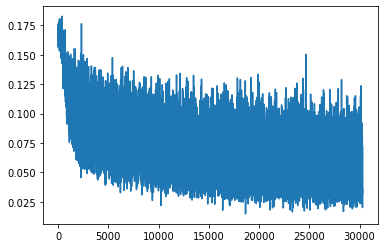

------
Subject:  24 Training Time 6148.614852666855 Best Test Acc:  0.9965986394557823
test subjects:  ['./seg\\c10', './seg\\x18']
*********
33423 890
32016 875
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6519367694854736
Eval Loss:  0.7211053967475891
Eval Loss:  0.6742326021194458
[[    3 19289]
 [   45 12679]]
              precision    recall  f1-score   support

           0       0.06      0.00      0.00     19292
           1       0.40      1.00      0.57     12724

    accuracy                           0.40     32016
   macro avg       0.23      0.50      0.28     32016
weighted avg       0.20      0.40      0.23     32016

acc:  0.3961144427786107
pre:  0.3966153653653

[[857  15]
 [  3   0]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       872
           1       0.00      0.00      0.00         3

    accuracy                           0.98       875
   macro avg       0.50      0.49      0.49       875
weighted avg       0.99      0.98      0.99       875

acc:  0.9794285714285714
pre:  0.0
rec:  0.0
ma F1:  0.4948036951501154
mi F1:  0.9794285714285714
we F1:  0.9862144506763443
Loss:  0.08718904852867126
Loss:  0.062120284885168076
Loss:  0.07503891736268997
15 **********
epoch:  16
Loss:  0.06209542602300644
Loss:  0.0525490827858448
Loss:  0.08192617446184158
16 **********
epoch:  17
Loss:  0.02968018129467964
Loss:  0.05152994766831398
Loss:  0.08444886654615402
17 **********
epoch:  18
Eval Loss:  0.0344548225402832
Eval Loss:  0.0045049190521240234
Eval Loss:  0.043807387351989746
[[18602   690]
 [ 3315  9409]]
              precision    recall  f1-score   support

           0       0.8

[[772 100]
 [  3   0]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       872
           1       0.00      0.00      0.00         3

    accuracy                           0.88       875
   macro avg       0.50      0.44      0.47       875
weighted avg       0.99      0.88      0.93       875

acc:  0.8822857142857143
pre:  0.0
rec:  0.0
ma F1:  0.4687310261080753
mi F1:  0.8822857142857143
we F1:  0.9342478966085523
Loss:  0.08481373637914658
Loss:  0.051121942698955536
Loss:  0.04553160071372986
33 **********
epoch:  34
Loss:  0.0456770583987236
Loss:  0.04724469035863876
Loss:  0.07106267660856247
34 **********
epoch:  35
Loss:  0.09492853283882141
Loss:  0.03734583035111427
Loss:  0.04511239752173424
35 **********
epoch:  36
Eval Loss:  0.013438940048217773
Eval Loss:  0.003007173538208008
Eval Loss:  0.01992511749267578
[[18373   919]
 [ 2286 10438]]
              precision    recall  f1-score   support

           0       0.8

[[822  50]
 [  3   0]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       872
           1       0.00      0.00      0.00         3

    accuracy                           0.94       875
   macro avg       0.50      0.47      0.48       875
weighted avg       0.99      0.94      0.97       875

acc:  0.9394285714285714
pre:  0.0
rec:  0.0
ma F1:  0.4843842074248674
mi F1:  0.9394285714285714
we F1:  0.9654469231416786
Loss:  0.0704549103975296
Loss:  0.07324417680501938
Loss:  0.03528929501771927
51 **********
epoch:  52
Loss:  0.048249561339616776
Loss:  0.04811643436551094
Loss:  0.0517524853348732
52 **********
epoch:  53
Loss:  0.0724748894572258
Loss:  0.03898836299777031
Loss:  0.048695601522922516
53 **********
epoch:  54
Eval Loss:  0.00974726676940918
Eval Loss:  0.002059459686279297
Eval Loss:  0.01333928108215332
[[17820  1472]
 [ 1504 11220]]
              precision    recall  f1-score   support

           0       0.92 

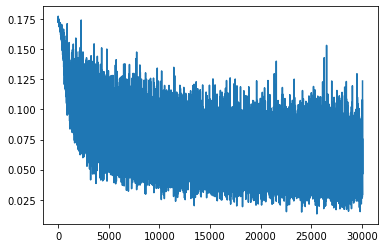

------
Subject:  25 Training Time 5817.549056053162 Best Test Acc:  0.9817142857142858
test subjects:  ['./seg\\x02']
*********
33844 469
32422 469
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6437027454376221
Eval Loss:  0.7129105925559998
Eval Loss:  0.6410883665084839
[[  379 19525]
 [  308 12210]]
              precision    recall  f1-score   support

           0       0.55      0.02      0.04     19904
           1       0.38      0.98      0.55     12518

    accuracy                           0.39     32422
   macro avg       0.47      0.50      0.29     32422
weighted avg       0.49      0.39      0.24     32422

acc:  0.3882857319104312
pre:  0.3847487001733102
rec:  0.97

[[253   7]
 [ 64 145]]
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       260
           1       0.95      0.69      0.80       209

    accuracy                           0.85       469
   macro avg       0.88      0.83      0.84       469
weighted avg       0.87      0.85      0.84       469

acc:  0.8486140724946695
pre:  0.9539473684210527
rec:  0.69377990430622
ma F1:  0.8401369198788269
mi F1:  0.8486140724946695
we F1:  0.8441400197251969
Loss:  0.04947034642100334
Loss:  0.06642884016036987
Loss:  0.09442103654146194
15 **********
epoch:  16
Loss:  0.05674048140645027
Loss:  0.04692543298006058
Loss:  0.09961455315351486
16 **********
epoch:  17
Loss:  0.062081027776002884
Loss:  0.0632084384560585
Loss:  0.07684505730867386
17 **********
epoch:  18
Eval Loss:  1.31813383102417
Eval Loss:  0.014595985412597656
Eval Loss:  0.13438916206359863
[[19283   621]
 [ 3487  9031]]
              precision    recall  f1-score   support

[[259   1]
 [162  47]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       260
           1       0.98      0.22      0.37       209

    accuracy                           0.65       469
   macro avg       0.80      0.61      0.56       469
weighted avg       0.78      0.65      0.58       469

acc:  0.652452025586354
pre:  0.9791666666666666
rec:  0.22488038277511962
ma F1:  0.5632024317637715
mi F1:  0.652452025586354
we F1:  0.5846728529192041
Loss:  0.05014272779226303
Loss:  0.04674608260393143
Loss:  0.08123861253261566
33 **********
epoch:  34
Loss:  0.06759735941886902
Loss:  0.06400447338819504
Loss:  0.0705040842294693
34 **********
epoch:  35
Loss:  0.09685791283845901
Loss:  0.07747316360473633
Loss:  0.062424346804618835
35 **********
epoch:  36
Eval Loss:  0.5100367069244385
Eval Loss:  0.0374600887298584
Eval Loss:  0.06440365314483643
[[18981   923]
 [ 1970 10548]]
              precision    recall  f1-score   suppor

[[260   0]
 [189  20]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       260
           1       1.00      0.10      0.17       209

    accuracy                           0.60       469
   macro avg       0.79      0.55      0.45       469
weighted avg       0.77      0.60      0.48       469

acc:  0.5970149253731343
pre:  1.0
rec:  0.09569377990430622
ma F1:  0.4540499257826695
mi F1:  0.5970149253731343
we F1:  0.48442998819564326
Loss:  0.07847873866558075
Loss:  0.036259882152080536
Loss:  0.053672149777412415
51 **********
epoch:  52
Loss:  0.06707878410816193
Loss:  0.06041868031024933
Loss:  0.06416888535022736
52 **********
epoch:  53
Loss:  0.057236067950725555
Loss:  0.059292908757925034
Loss:  0.055073291063308716
53 **********
epoch:  54
Eval Loss:  0.5438790321350098
Eval Loss:  0.057274460792541504
Eval Loss:  0.03883635997772217
[[18600  1304]
 [ 1328 11190]]
              precision    recall  f1-score   support

  

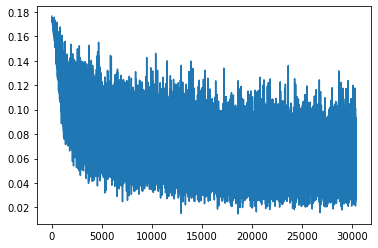

------
Subject:  26 Training Time 5861.5424263477325 Best Test Acc:  0.8869936034115139
test subjects:  ['./seg\\x06', './seg\\x24']
*********
33434 879
32025 866
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6328914761543274
Eval Loss:  0.6482917666435242
Eval Loss:  0.7475433349609375
[[19253    46]
 [12628    98]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     19299
           1       0.68      0.01      0.02     12726

    accuracy                           0.60     32025
   macro avg       0.64      0.50      0.38     32025
weighted avg       0.63      0.60      0.46     32025

acc:  0.6042466822794692
pre:  0.680555555555

[[858   7]
 [  0   1]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       865
           1       0.12      1.00      0.22         1

    accuracy                           0.99       866
   macro avg       0.56      1.00      0.61       866
weighted avg       1.00      0.99      1.00       866

acc:  0.9919168591224018
pre:  0.125
rec:  1.0
ma F1:  0.609079770426259
mi F1:  0.9919168591224018
we F1:  0.9950438831840971
Subject 27 Current Train Acc:  0.8852771272443404 Current Test Acc:  0.9919168591224018
Loss:  0.08374734967947006
Loss:  0.053376246243715286
Loss:  0.07559037208557129
15 **********
epoch:  16
Loss:  0.05562172457575798
Loss:  0.06082889810204506
Loss:  0.04884762316942215
16 **********
epoch:  17
Loss:  0.08772612363100052
Loss:  0.07394696027040482
Loss:  0.0662824809551239
17 **********
epoch:  18
Eval Loss:  0.13739579916000366
Eval Loss:  0.03827095031738281
Eval Loss:  0.041121482849121094
[[18382   917]
 [ 24

Eval Loss:  0.0267641544342041
[[18308   991]
 [ 2014 10712]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     19299
           1       0.92      0.84      0.88     12726

    accuracy                           0.91     32025
   macro avg       0.91      0.90      0.90     32025
weighted avg       0.91      0.91      0.91     32025

acc:  0.9061670569867292
pre:  0.9153208578996839
rec:  0.8417413169888417
ma F1:  0.9005734219362005
mi F1:  0.9061670569867292
we F1:  0.9054137277796871
[[860   5]
 [  0   1]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       865
           1       0.17      1.00      0.29         1

    accuracy                           0.99       866
   macro avg       0.58      1.00      0.64       866
weighted avg       1.00      0.99      1.00       866

acc:  0.9942263279445728
pre:  0.16666666666666666
rec:  1.0
ma F1:  0.641407867494824
mi F1:  0.99422632

Loss:  0.07921531051397324
Loss:  0.058049093931913376
48 **********
epoch:  49
Loss:  0.0568162240087986
Loss:  0.04010334983468056
Loss:  0.046269491314888
49 **********
epoch:  50
Loss:  0.05111328139901161
Loss:  0.04147611930966377
Loss:  0.056704334914684296
50 **********
epoch:  51
Eval Loss:  0.6975538730621338
Eval Loss:  0.2123073935508728
Eval Loss:  0.010264158248901367
[[18001  1298]
 [ 1336 11390]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     19299
           1       0.90      0.90      0.90     12726

    accuracy                           0.92     32025
   macro avg       0.91      0.91      0.91     32025
weighted avg       0.92      0.92      0.92     32025

acc:  0.9177517564402811
pre:  0.8976986128625473
rec:  0.895018073235895
ma F1:  0.9140907898669408
mi F1:  0.9177517564402812
we F1:  0.917730713219923
[[859   6]
 [  0   1]]
              precision    recall  f1-score   support

           0       1.00  

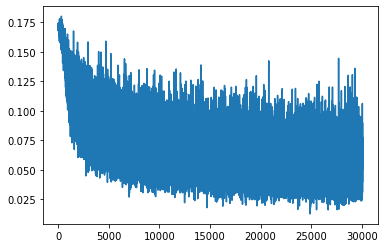

------
Subject:  27 Training Time 5797.11269903183 Best Test Acc:  0.9965357967667436
test subjects:  ['./seg\\x09', './seg\\x23']
*********
33278 1035
31856 1035
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7447819113731384
Eval Loss:  0.6239511370658875
Eval Loss:  0.7543337345123291
[[   24 19391]
 [   70 12371]]
              precision    recall  f1-score   support

           0       0.26      0.00      0.00     19415
           1       0.39      0.99      0.56     12441

    accuracy                           0.39     31856
   macro avg       0.32      0.50      0.28     31856
weighted avg       0.31      0.39      0.22     31856

acc:  0.38909467604218984
pre:  0.38949058623

[[703  46]
 [ 82 204]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       749
           1       0.82      0.71      0.76       286

    accuracy                           0.88      1035
   macro avg       0.86      0.83      0.84      1035
weighted avg       0.87      0.88      0.87      1035

acc:  0.8763285024154589
pre:  0.816
rec:  0.7132867132867133
ma F1:  0.8388760240518398
mi F1:  0.8763285024154589
we F1:  0.8736265200084644
Loss:  0.07255272567272186
Loss:  0.04681196063756943
Loss:  0.04414863884449005
15 **********
epoch:  16
Loss:  0.08292397111654282
Loss:  0.06617504358291626
Loss:  0.06469065696001053
16 **********
epoch:  17
Loss:  0.10727290064096451
Loss:  0.0656125396490097
Loss:  0.09287890791893005
17 **********
epoch:  18
Eval Loss:  0.00775456428527832
Eval Loss:  0.10224711894989014
Eval Loss:  0.1176939606666565
[[18171  1244]
 [ 2188 10253]]
              precision    recall  f1-score   support

         

[[651  98]
 [ 77 209]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       749
           1       0.68      0.73      0.70       286

    accuracy                           0.83      1035
   macro avg       0.79      0.80      0.79      1035
weighted avg       0.84      0.83      0.83      1035

acc:  0.8309178743961353
pre:  0.6807817589576547
rec:  0.7307692307692307
ma F1:  0.7932034877680362
mi F1:  0.8309178743961353
we F1:  0.8327097343943028
Loss:  0.056932322680950165
Loss:  0.05817331373691559
Loss:  0.07796257734298706
33 **********
epoch:  34
Loss:  0.06642846018075943
Loss:  0.06642621010541916
Loss:  0.06342756003141403
34 **********
epoch:  35
Loss:  0.05463045835494995
Loss:  0.0633721798658371
Loss:  0.05850888043642044
35 **********
epoch:  36
Eval Loss:  0.0040493011474609375
Eval Loss:  0.140896737575531
Eval Loss:  0.01851344108581543
[[18474   941]
 [ 2096 10345]]
              precision    recall  f1-score   sup

[[650  99]
 [108 178]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       749
           1       0.64      0.62      0.63       286

    accuracy                           0.80      1035
   macro avg       0.75      0.75      0.75      1035
weighted avg       0.80      0.80      0.80      1035

acc:  0.8
pre:  0.6425992779783394
rec:  0.6223776223776224
ma F1:  0.747483914615159
mi F1:  0.8000000000000002
we F1:  0.7989986339651197
Loss:  0.0743342787027359
Loss:  0.03837261348962784
Loss:  0.06124784052371979
51 **********
epoch:  52
Loss:  0.046211402863264084
Loss:  0.06521736085414886
Loss:  0.04745825007557869
52 **********
epoch:  53
Loss:  0.07183059304952621
Loss:  0.05144553631544113
Loss:  0.10103302448987961
53 **********
epoch:  54
Eval Loss:  0.003000020980834961
Eval Loss:  0.060158610343933105
Eval Loss:  0.05629837512969971
[[18380  1035]
 [ 1515 10926]]
              precision    recall  f1-score   support

        

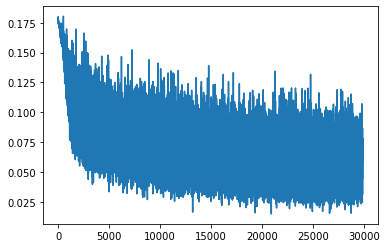

------
Subject:  28 Training Time 5792.496042728424 Best Test Acc:  0.8801932367149758
test subjects:  ['./seg\\x10']
*********
33803 510
32381 510
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.6447755694389343
Eval Loss:  0.7216736674308777
Eval Loss:  0.6712031364440918
[[19629   121]
 [12274   357]]
              precision    recall  f1-score   support

           0       0.62      0.99      0.76     19750
           1       0.75      0.03      0.05     12631

    accuracy                           0.62     32381
   macro avg       0.68      0.51      0.41     32381
weighted avg       0.67      0.62      0.48     32381

acc:  0.6172137982150027
pre:  0.7468619246861925
rec:  0.02

[[390  24]
 [ 44  52]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       414
           1       0.68      0.54      0.60        96

    accuracy                           0.87       510
   macro avg       0.79      0.74      0.76       510
weighted avg       0.86      0.87      0.86       510

acc:  0.8666666666666667
pre:  0.6842105263157895
rec:  0.5416666666666666
ma F1:  0.7622312417727073
mi F1:  0.8666666666666667
we F1:  0.8604870557261957
Subject 29 Current Train Acc:  0.8819987029430839 Current Test Acc:  0.8666666666666667
Loss:  0.08740998804569244
Loss:  0.11082141101360321
Loss:  0.05605668947100639
15 **********
epoch:  16
Loss:  0.051085215061903
Loss:  0.048912957310676575
Loss:  0.0958682969212532
16 **********
epoch:  17
Loss:  0.06617515534162521
Loss:  0.05412052199244499
Loss:  0.054474614560604095
17 **********
epoch:  18
Eval Loss:  0.004357337951660156
Eval Loss:  0.03309178352355957
Eval Loss:  0.2319736480

Eval Loss:  0.09403693675994873
[[18306  1444]
 [ 1400 11231]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     19750
           1       0.89      0.89      0.89     12631

    accuracy                           0.91     32381
   macro avg       0.91      0.91      0.91     32381
weighted avg       0.91      0.91      0.91     32381

acc:  0.9121707173960039
pre:  0.8860749506903353
rec:  0.8891615865727179
ma F1:  0.90776764663295
mi F1:  0.9121707173960039
we F1:  0.912198100450926
[[236 178]
 [ 10  86]]
              precision    recall  f1-score   support

           0       0.96      0.57      0.72       414
           1       0.33      0.90      0.48        96

    accuracy                           0.63       510
   macro avg       0.64      0.73      0.60       510
weighted avg       0.84      0.63      0.67       510

acc:  0.6313725490196078
pre:  0.32575757575757575
rec:  0.8958333333333334
ma F1:  0.5964646464646465
mi F

Loss:  0.1050202026963234
Loss:  0.04668653383851051
Loss:  0.057646870613098145
48 **********
epoch:  49
Loss:  0.06781325489282608
Loss:  0.044885989278554916
Loss:  0.02968280389904976
49 **********
epoch:  50
Loss:  0.059539325535297394
Loss:  0.06200185418128967
Loss:  0.040530286729335785
50 **********
epoch:  51
Eval Loss:  0.002240419387817383
Eval Loss:  0.008258819580078125
Eval Loss:  0.03101050853729248
[[18860   890]
 [ 1801 10830]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     19750
           1       0.92      0.86      0.89     12631

    accuracy                           0.92     32381
   macro avg       0.92      0.91      0.91     32381
weighted avg       0.92      0.92      0.92     32381

acc:  0.9168957104474846
pre:  0.924061433447099
rec:  0.8574142981553321
ma F1:  0.9114502057943275
mi F1:  0.9168957104474846
we F1:  0.9162779203180916
[[305 109]
 [ 20  76]]
              precision    recall  f1-score  

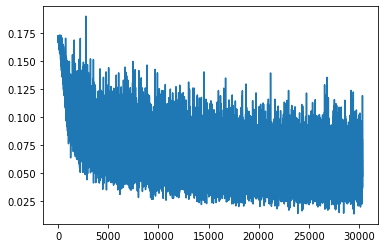

------
Subject:  29 Training Time 5858.1225707530975 Best Test Acc:  0.8745098039215686
test subjects:  ['./seg\\x13', './seg\\x26']
*********
33287 1026
31865 1026
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.8185309171676636
Eval Loss:  0.6071194410324097
Eval Loss:  0.8312610387802124
[[    0 19774]
 [    0 12091]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19774
           1       0.38      1.00      0.55     12091

    accuracy                           0.38     31865
   macro avg       0.19      0.50      0.28     31865
weighted avg       0.14      0.38      0.21     31865

acc:  0.3794445316177624
pre:  0.3794445316

[[370  20]
 [482 154]]
              precision    recall  f1-score   support

           0       0.43      0.95      0.60       390
           1       0.89      0.24      0.38       636

    accuracy                           0.51      1026
   macro avg       0.66      0.60      0.49      1026
weighted avg       0.71      0.51      0.46      1026

acc:  0.5107212475633528
pre:  0.8850574712643678
rec:  0.24213836477987422
ma F1:  0.48803005904455177
mi F1:  0.5107212475633528
we F1:  0.4621873165648062
Loss:  0.07069321721792221
Loss:  0.08394157141447067
Loss:  0.05434253811836243
15 **********
epoch:  16
Loss:  0.03954802826046944
Loss:  0.0688156709074974
Loss:  0.1084485650062561
16 **********
epoch:  17
Loss:  0.06374980509281158
Loss:  0.056130167096853256
Loss:  0.05356356129050255
17 **********
epoch:  18
Eval Loss:  0.14136803150177002
Eval Loss:  3.082228183746338
Eval Loss:  0.007359981536865234
[[18307  1467]
 [ 1700 10391]]
              precision    recall  f1-score   sup

[[375  15]
 [455 181]]
              precision    recall  f1-score   support

           0       0.45      0.96      0.61       390
           1       0.92      0.28      0.44       636

    accuracy                           0.54      1026
   macro avg       0.69      0.62      0.52      1026
weighted avg       0.74      0.54      0.50      1026

acc:  0.5419103313840156
pre:  0.923469387755102
rec:  0.28459119496855345
ma F1:  0.5249251261034048
mi F1:  0.5419103313840156
we F1:  0.503387185386754
Loss:  0.034779734909534454
Loss:  0.08828603476285934
Loss:  0.053022075444459915
33 **********
epoch:  34
Loss:  0.05726849287748337
Loss:  0.05884840339422226
Loss:  0.045499932020902634
34 **********
epoch:  35
Loss:  0.04250460863113403
Loss:  0.07040916383266449
Loss:  0.08922471106052399
35 **********
epoch:  36
Eval Loss:  0.041355013847351074
Eval Loss:  5.043421745300293
Eval Loss:  0.0045354366302490234
[[19292   482]
 [ 2741  9350]]
              precision    recall  f1-score   

[[384   6]
 [514 122]]
              precision    recall  f1-score   support

           0       0.43      0.98      0.60       390
           1       0.95      0.19      0.32       636

    accuracy                           0.49      1026
   macro avg       0.69      0.59      0.46      1026
weighted avg       0.75      0.49      0.42      1026

acc:  0.49317738791423
pre:  0.953125
rec:  0.1918238993710692
ma F1:  0.4578225098370785
mi F1:  0.49317738791423
we F1:  0.42462670828372245
Loss:  0.04435105621814728
Loss:  0.06624878197908401
Loss:  0.04236561805009842
51 **********
epoch:  52
Loss:  0.04799279570579529
Loss:  0.040036365389823914
Loss:  0.0911364033818245
52 **********
epoch:  53
Loss:  0.05842247232794762
Loss:  0.05646056309342384
Loss:  0.03248249366879463
53 **********
epoch:  54
Eval Loss:  0.09719884395599365
Eval Loss:  2.468506336212158
Eval Loss:  0.0029234886169433594
[[18836   938]
 [ 1550 10541]]
              precision    recall  f1-score   support

       

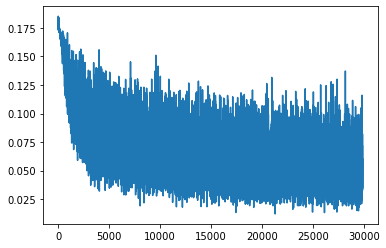

------
Subject:  30 Training Time 5996.24725317955 Best Test Acc:  0.6539961013645225
test subjects:  ['./seg\\x17', './seg\\x22']
*********
33431 882
32353 538
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.7531260848045349
Eval Loss:  0.7213926315307617
Eval Loss:  0.7357646822929382
[[   95 19533]
 [  129 12596]]
              precision    recall  f1-score   support

           0       0.42      0.00      0.01     19628
           1       0.39      0.99      0.56     12725

    accuracy                           0.39     32353
   macro avg       0.41      0.50      0.29     32353
weighted avg       0.41      0.39      0.23     32353

acc:  0.39226655951534634
pre:  0.3920445703258

[[529   7]
 [  1   1]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       536
           1       0.12      0.50      0.20         2

    accuracy                           0.99       538
   macro avg       0.56      0.74      0.60       538
weighted avg       0.99      0.99      0.99       538

acc:  0.9851301115241635
pre:  0.125
rec:  0.5
ma F1:  0.5962476547842401
mi F1:  0.9851301115241635
we F1:  0.9895492303507535
Loss:  0.06711418926715851
Loss:  0.09017488360404968
Loss:  0.06449753046035767
15 **********
epoch:  16
Loss:  0.061705365777015686
Loss:  0.08834289759397507
Loss:  0.07782581448554993
16 **********
epoch:  17
Loss:  0.07913971692323685
Loss:  0.06898127496242523
Loss:  0.06296364963054657
17 **********
epoch:  18
Eval Loss:  0.2879623770713806
Eval Loss:  0.018564701080322266
Eval Loss:  0.008145570755004883
[[18086  1542]
 [ 2162 10563]]
              precision    recall  f1-score   support

           0       0

[[532   4]
 [  1   1]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       536
           1       0.20      0.50      0.29         2

    accuracy                           0.99       538
   macro avg       0.60      0.75      0.64       538
weighted avg       1.00      0.99      0.99       538

acc:  0.9907063197026023
pre:  0.2
rec:  0.5
ma F1:  0.6405185086195375
mi F1:  0.9907063197026023
we F1:  0.9926847819121107
Loss:  0.08167903125286102
Loss:  0.049281973391771317
Loss:  0.08370178937911987
33 **********
epoch:  34
Loss:  0.06962461769580841
Loss:  0.058212459087371826
Loss:  0.07433663308620453
34 **********
epoch:  35
Loss:  0.061359260231256485
Loss:  0.06814046204090118
Loss:  0.06842048466205597
35 **********
epoch:  36
Eval Loss:  0.6253386735916138
Eval Loss:  0.014335393905639648
Eval Loss:  0.002077341079711914
[[18304  1324]
 [ 1604 11121]]
              precision    recall  f1-score   support

           0       0

[[536   0]
 [  2   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       0.00      0.00      0.00         2

    accuracy                           1.00       538
   macro avg       0.50      0.50      0.50       538
weighted avg       0.99      1.00      0.99       538

acc:  0.9962825278810409
pre:  0.0
rec:  0.0
ma F1:  0.49906890130353815
mi F1:  0.9962825278810409
we F1:  0.9944272531550055
Loss:  0.05572459474205971
Loss:  0.07872763276100159
Loss:  0.07988506555557251
51 **********
epoch:  52
Loss:  0.043924905359745026
Loss:  0.037292852997779846
Loss:  0.07243729382753372
52 **********
epoch:  53
Loss:  0.059591829776763916
Loss:  0.09617775678634644
Loss:  0.05640522390604019
53 **********
epoch:  54
Eval Loss:  0.5182658433914185
Eval Loss:  0.009009361267089844
Eval Loss:  0.0012240409851074219
[[18211  1417]
 [ 1286 11439]]
              precision    recall  f1-score   support

           0      

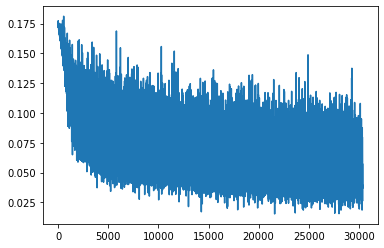

------
Subject:  31 Training Time 5882.562224149704 Best Test Acc:  0.9962825278810409
test subjects:  ['./seg\\x31', './seg\\x32']
*********
33218 1095
31796 1095
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
Eval Loss:  0.5676442384719849
Eval Loss:  0.8330312967300415
Eval Loss:  0.8010936379432678
[[    0 20010]
 [    0 11786]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20010
           1       0.37      1.00      0.54     11786

    accuracy                           0.37     31796
   macro avg       0.19      0.50      0.27     31796
weighted avg       0.14      0.37      0.20     31796

acc:  0.3706755566737954
pre:  0.37067555667

[[139  15]
 [ 88 853]]
              precision    recall  f1-score   support

           0       0.61      0.90      0.73       154
           1       0.98      0.91      0.94       941

    accuracy                           0.91      1095
   macro avg       0.80      0.90      0.84      1095
weighted avg       0.93      0.91      0.91      1095

acc:  0.9059360730593607
pre:  0.9827188940092166
rec:  0.9064824654622742
ma F1:  0.836360629050722
mi F1:  0.9059360730593607
we F1:  0.9130495288193476
Subject 32 Current Train Acc:  0.8770600075481193 Current Test Acc:  0.9059360730593607
Loss:  0.08767709881067276
Loss:  0.07686404883861542
Loss:  0.06986475735902786
15 **********
epoch:  16
Loss:  0.07931375503540039
Loss:  0.06863869726657867
Loss:  0.07484053075313568
16 **********
epoch:  17
Loss:  0.0912182480096817
Loss:  0.06616752594709396
Loss:  0.09664727002382278
17 **********
epoch:  18
Eval Loss:  0.07938694953918457
Eval Loss:  0.007029533386230469
Eval Loss:  0.29716473817

Eval Loss:  0.035860419273376465
[[18587  1423]
 [ 1812  9974]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     20010
           1       0.88      0.85      0.86     11786

    accuracy                           0.90     31796
   macro avg       0.89      0.89      0.89     31796
weighted avg       0.90      0.90      0.90     31796

acc:  0.898257642470751
pre:  0.8751425813810652
rec:  0.8462582725267266
ma F1:  0.8902008356095823
mi F1:  0.898257642470751
we F1:  0.8978937625370468
[[149   5]
 [136 805]]
              precision    recall  f1-score   support

           0       0.52      0.97      0.68       154
           1       0.99      0.86      0.92       941

    accuracy                           0.87      1095
   macro avg       0.76      0.91      0.80      1095
weighted avg       0.93      0.87      0.89      1095

acc:  0.8712328767123287
pre:  0.9938271604938271
rec:  0.8554729011689692
ma F1:  0.7991450378501579
mi 

Loss:  0.04614965245127678
Loss:  0.0459587462246418
Loss:  0.04435030370950699
48 **********
epoch:  49
Loss:  0.0886215791106224
Loss:  0.06392153352499008
Loss:  0.04211891442537308
49 **********
epoch:  50
Loss:  0.027211979031562805
Loss:  0.07490206509828568
Loss:  0.028272751718759537
50 **********
epoch:  51
Eval Loss:  0.02182137966156006
Eval Loss:  0.0010123252868652344
Eval Loss:  0.12873291969299316
[[18846  1164]
 [ 1460 10326]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     20010
           1       0.90      0.88      0.89     11786

    accuracy                           0.92     31796
   macro avg       0.91      0.91      0.91     31796
weighted avg       0.92      0.92      0.92     31796

acc:  0.9174738960875581
pre:  0.8986945169712793
rec:  0.8761242151705413
ma F1:  0.9110900156166184
mi F1:  0.9174738960875581
we F1:  0.9172521086909151
[[147   7]
 [109 832]]
              precision    recall  f1-score   s

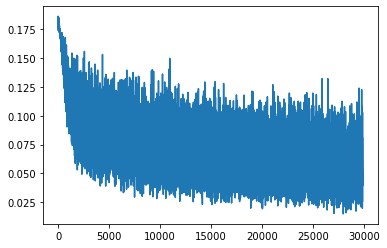

------
Subject:  32 Training Time 5815.797738790512 Best Test Acc:  0.9187214611872146


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_acc=[]
for fold in range(1,33):
    begin=time()
    train_dtlist,test_dtlist=getTrainTestList(reclist,opt='leaveonepatient',fold=fold)#fold 1-10
    print('*********')
    print(len(train_dtlist),len(test_dtlist))
    train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
    np.random.shuffle(train_dtlist)
    test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
    print(len(train_dtlist),len(test_dtlist))
    
    train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
    #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, sampler=None, num_workers=0)
    #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=False, sampler=None, num_workers=0)
    len(train_dataset),len(train_loader)#,len(test_dataset)
    
    model=MyLSTM(2,100).to(device)
    #model=alexnet(num_classes=2)
    #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.1)
                print(m,'init')
            else:
                print('Not initializing')
    criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
    #criterion = CircleLoss(m=0.25, gamma=256)
    opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=20,eta_min=0.000005)
    loss_list=[]
    max_test=0
    opt.zero_grad()
    epoch_flag=0
    test_acc=0
    for epoch in range(60):
        print('epoch: ', epoch)
        if epoch_flag%3==0:# and epoch_flag!=0:
            model.eval()
            tmp_train_acc=eval(model,train_dtlist,criterion)
            #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
            tmp_test_acc=eval(model,test_dtlist,criterion)

            if tmp_test_acc >test_acc:
                test_acc=tmp_test_acc.copy()
                torch.save(model.state_dict(),'LeaveOneParamSub_%.0f.pkl'%(fold))
                print('Subject',fold,'Current Train Acc: ',tmp_train_acc,'Current Test Acc: ',test_acc)
            model.train()

        flag=0
        accum_flag=0
        for fe, label in train_loader:
            fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

            label=label.long().to(device)
            pred_prob_no_softmax=model(fe)
            loss=criterion(pred_prob_no_softmax,label)/4#/256
            del label
            del fe
            #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
            #loss = criterion(inp_sp, inp_sn)/256

            loss_list.append(loss.item())
            loss.backward()
            accum_flag+=1
            if accum_flag%4==0:
                opt.step()
                accum_flag=0
                opt.zero_grad()
            flag+=1
            if flag%128==0:
                print("Loss: ", loss.item())

            #print('step')
        print(epoch_flag,'*'*10)
        epoch_flag+=1
        #scheduler.step()

    plt.plot(loss_list)
    plt.show()
    plt.close('all')
    print('------')
    print('Subject: ', fold, 'Training Time', time()-begin,'Best Test Acc: ',test_acc)
    final_acc.append(test_acc)
    print(final_acc)

In [ ]:
# <!-- 
# [[ 63  82]
#  [ 68 785]]
#               precision    recall  f1-score   support

#            0       0.48      0.43      0.46       145
#            1       0.91      0.92      0.91       853

#     accuracy                           0.85       998
#    macro avg       0.69      0.68      0.68       998
# weighted avg       0.84      0.85      0.85       998

# acc:  0.8496993987975952
# pre:  0.9054209919261822
# rec:  0.9202813599062134
# ma F1:  0.6846562184024267
# mi F1:  0.8496993987975952
# we F1:  0.8464991155212345
# Subject 1 Current Train Acc:  0.900573793622425 Current Test Acc:  0.8496993987975
        
# [[120  39]
#  [469 390]]
#               precision    recall  f1-score   support

#            0       0.20      0.75      0.32       159
#            1       0.91      0.45      0.61       859

#     accuracy                           0.50      1018
#    macro avg       0.56      0.60      0.46      1018
# weighted avg       0.80      0.50      0.56      1018

# acc:  0.5009823182711198
# pre:  0.9090909090909091
# rec:  0.4540162980209546
# ma F1:  0.46322283854253166
# mi F1:  0.5009823182711198
# we F1:  0.5611177859870196
# Subject 2 Current Train Acc:  0.919900856524331 Current Test Acc:  0.5009823182711
        
# [[288  65]
#  [ 77 576]]
#               precision    recall  f1-score   support

#            0       0.79      0.82      0.80       353
#            1       0.90      0.88      0.89       653

#     accuracy                           0.86      1006
#    macro avg       0.84      0.85      0.85      1006
# weighted avg       0.86      0.86      0.86      1006

# acc:  0.8588469184890656
# pre:  0.8985959438377535
# rec:  0.8820826952526799
# ma F1:  0.8462455817077319
# mi F1:  0.8588469184890656
# we F1:  0.8593719741882879
# Subject 3 Current Train Acc:  0.9203387172651717 Current Test Acc:  0.858846918489
        
# [[ 54   6]
#  [148 523]]
#               precision    recall  f1-score   support

#            0       0.27      0.90      0.41        60
#            1       0.99      0.78      0.87       671

#     accuracy                           0.79       731
#    macro avg       0.63      0.84      0.64       731
# weighted avg       0.93      0.79      0.83       731

# acc:  0.7893296853625171
# pre:  0.9886578449905482
# rec:  0.7794336810730254
# ma F1:  0.6419402035623409
# mi F1:  0.7893296853625171
# we F1:  0.8339550721762164
# Subject 4 Current Train Acc:  0.9038246268656717 Current Test Acc:  0.789329685362
        
# [[849 210]
#  [356 575]]
#               precision    recall  f1-score   support

#            0       0.70      0.80      0.75      1059
#            1       0.73      0.62      0.67       931

#     accuracy                           0.72      1990
#    macro avg       0.72      0.71      0.71      1990
# weighted avg       0.72      0.72      0.71      1990

# acc:  0.7155778894472362
# pre:  0.732484076433121
# rec:  0.6176154672395274
# ma F1:  0.7100815850815851
# mi F1:  0.7155778894472362
# we F1:  0.7126492017195536
# Subject 5 Current Train Acc:  0.8792595708876736 Current Test Acc:  0.715577889447
        
# [[531  71]
#  [107 299]]
#               precision    recall  f1-score   support

#            0       0.83      0.88      0.86       602
#            1       0.81      0.74      0.77       406

#     accuracy                           0.82      1008
#    macro avg       0.82      0.81      0.81      1008
# weighted avg       0.82      0.82      0.82      1008

# acc:  0.8234126984126984
# pre:  0.8081081081081081
# rec:  0.7364532019704434
# ma F1:  0.8135350848021283
# mi F1:  0.8234126984126985
# we F1:  0.8218799652662304
# Subject 6 Current Train Acc:  0.9191732271116269 Current Test Acc:  0.823412698412

# [[18018  1472]
#  [ 1119 10265]]
#               precision    recall  f1-score   support

#            0       0.94      0.92      0.93     19490
#            1       0.87      0.90      0.89     11384

#     accuracy                           0.92     30874
#    macro avg       0.91      0.91      0.91     30874
# weighted avg       0.92      0.92      0.92     30874

# acc:  0.9160782535466736
# pre:  0.874584646843316
# rec:  0.9017041461700632
# ma F1:  0.9104299700336314
# mi F1:  0.9160782535466736
# we F1:  0.9163354242006274
# [[ 456  218]
#  [ 155 1188]]
#               precision    recall  f1-score   support

#            0       0.75      0.68      0.71       674
#            1       0.84      0.88      0.86      1343

#     accuracy                           0.82      2017
#    macro avg       0.80      0.78      0.79      2017
# weighted avg       0.81      0.82      0.81      2017

# acc:  0.8150718889439762
# pre:  0.844950213371266
# rec:  0.8845867460908414
# ma F1:  0.7870209612834098
# mi F1:  0.8150718889439762
# we F1:  0.8126576697600749
# Subject 7 Current Train Acc:  0.9160782535466736 Current Test Acc:  0.815071888943

# [[727  83]
#  [256 439]]
#               precision    recall  f1-score   support

#            0       0.74      0.90      0.81       810
#            1       0.84      0.63      0.72       695

#     accuracy                           0.77      1505
#    macro avg       0.79      0.76      0.77      1505
# weighted avg       0.79      0.77      0.77      1505

# acc:  0.774750830564784
# pre:  0.8409961685823755
# rec:  0.6316546762589929
# ma F1:  0.7661887895087305
# mi F1:  0.774750830564784
# we F1:  0.7696076600693075
# Subject 8 Current Train Acc:  0.9239788440706047 Current Test Acc:  0.774750830564

# [[156   9]
#  [424 395]]
#               precision    recall  f1-score   support

#            0       0.27      0.95      0.42       165
#            1       0.98      0.48      0.65       819

#     accuracy                           0.56       984
#    macro avg       0.62      0.71      0.53       984
# weighted avg       0.86      0.56      0.61       984

# acc:  0.5599593495934959
# pre:  0.9777227722772277
# rec:  0.4822954822954823
# ma F1:  0.5323722609712062
# mi F1:  0.5599593495934959
# we F1:  0.6078616164480992
# Subject 9 Current Train Acc:  0.9102704735637948 Current Test Acc:  0.559959349593

# [[221  23]
#  [130  92]]
#               precision    recall  f1-score   support

#            0       0.63      0.91      0.74       244
#            1       0.80      0.41      0.55       222

#     accuracy                           0.67       466
#    macro avg       0.71      0.66      0.64       466
# weighted avg       0.71      0.67      0.65       466

# acc:  0.6716738197424893
# pre:  0.8
# rec:  0.4144144144144144
# ma F1:  0.6444256040695209
# mi F1:  0.6716738197424893
# we F1:  0.6490725865873914
# Subject 10 Current Train Acc:  0.915065535851966 Current Test Acc:  0.671673819742

# [[ 125   90]
#  [ 187 1092]]
#               precision    recall  f1-score   support

#            0       0.40      0.58      0.47       215
#            1       0.92      0.85      0.89      1279

#     accuracy                           0.81      1494
#    macro avg       0.66      0.72      0.68      1494
# weighted avg       0.85      0.81      0.83      1494

# acc:  0.8145917001338688
# pre:  0.9238578680203046
# rec:  0.8537920250195465
# ma F1:  0.680913715055434
# mi F1:  0.8145917001338688
# we F1:  0.828000970612264
# Subject 11 Current Train Acc:  0.8126891104245628 Current Test Acc:  0.81459170013
# [[751  46]
#  [ 72 142]]
#               precision    recall  f1-score   support

#            0       0.91      0.94      0.93       797
#            1       0.76      0.66      0.71       214

#     accuracy                           0.88      1011
#    macro avg       0.83      0.80      0.82      1011
# weighted avg       0.88      0.88      0.88      1011

# acc:  0.8832838773491593
# pre:  0.7553191489361702
# rec:  0.6635514018691588
# ma F1:  0.8168140777593514
# mi F1:  0.8832838773491593
# we F1:  0.8804460862336667
# Subject 12 Current Train Acc:  0.9123902132998746 Current Test Acc:  0.88328387734

# [[ 729  169]
#  [ 126 1010]]
#               precision    recall  f1-score   support

#            0       0.85      0.81      0.83       898
#            1       0.86      0.89      0.87      1136

#     accuracy                           0.85      2034
#    macro avg       0.85      0.85      0.85      2034
# weighted avg       0.85      0.85      0.85      2034

# acc:  0.8549655850540806
# pre:  0.8566581849024597
# rec:  0.8890845070422535
# ma F1:  0.852143625429532
# mi F1:  0.8549655850540806
# we F1:  0.8545337549335981
# Subject 13 Current Train Acc:  0.9207635220533429 Current Test Acc:  0.85496558505

# [[917   4]
#  [ 31   0]]
#               precision    recall  f1-score   support

#            0       0.97      1.00      0.98       921
#            1       0.00      0.00      0.00        31

#     accuracy                           0.96       952
#    macro avg       0.48      0.50      0.49       952
# weighted avg       0.94      0.96      0.95       952

# acc:  0.9632352941176471
# pre:  0.0
# rec:  0.0
# ma F1:  0.49063670411985016
# mi F1:  0.9632352941176471
# we F1:  0.9493201775092059
# Subject 14 Current Train Acc:  0.9017189016562823 Current Test Acc:  0.96323529411

# [[1608   24]
#  [ 299   52]]
#               precision    recall  f1-score   support

#            0       0.84      0.99      0.91      1632
#            1       0.68      0.15      0.24       351

#     accuracy                           0.84      1983
#    macro avg       0.76      0.57      0.58      1983
# weighted avg       0.82      0.84      0.79      1983

# acc:  0.8371154815935451
# pre:  0.6842105263157895
# rec:  0.14814814814814814
# ma F1:  0.5761454994960802
# mi F1:  0.8371154815935451
# we F1:  0.7909928947832605
# Subject 15 Current Train Acc:  0.8769574220266597 Current Test Acc:  0.83711548159

# [[808  12]
#  [  9   1]]
#               precision    recall  f1-score   support

#            0       0.99      0.99      0.99       820
#            1       0.08      0.10      0.09        10

#     accuracy                           0.97       830
#    macro avg       0.53      0.54      0.54       830
# weighted avg       0.98      0.97      0.98       830

# acc:  0.9746987951807229
# pre:  0.07692307692307693
# rec:  0.1
# ma F1:  0.5370640886032243
# mi F1:  0.9746987951807229
# we F1:  0.9763256900007135
# Subject 16 Current Train Acc:  0.8277346308599233 Current Test Acc:  0.97469879518

# [[816   4]
#  [ 70   0]]
#               precision    recall  f1-score   support

#            0       0.92      1.00      0.96       820
#            1       0.00      0.00      0.00        70

#     accuracy                           0.92       890
#    macro avg       0.46      0.50      0.48       890
# weighted avg       0.85      0.92      0.88       890

# acc:  0.9168539325842696
# pre:  0.0
# rec:  0.0
# ma F1:  0.4783118405627198
# mi F1:  0.9168539325842696
# we F1:  0.8813836163178207
# Subject 17 Current Train Acc:  0.6041998687541015 Current Test Acc:  0.91685393258

# [[952]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       952

#     accuracy                           1.00       952
#    macro avg       1.00      1.00      1.00       952
# weighted avg       1.00      1.00      1.00       952

# acc:  1.0
# pre:  0.0
# rec:  0.0
# ma F1:  1.0
# mi F1:  1.0
# we F1:  1.0
# Subject 18 Current Train Acc:  0.6013337925420332 Current Test Acc:  1.0

# [[938  10]
#  [  2   1]]
#               precision    recall  f1-score   support

#            0       1.00      0.99      0.99       948
#            1       0.09      0.33      0.14         3

#     accuracy                           0.99       951
#    macro avg       0.54      0.66      0.57       951
# weighted avg       1.00      0.99      0.99       951

# acc:  0.9873817034700315
# pre:  0.09090909090909091
# rec:  0.3333333333333333
# ma F1:  0.5682506053268765
# mi F1:  0.9873817034700315
# we F1:  0.9909601973709337
# Subject 19 Current Train Acc:  0.843143393863494 Current Test Acc:  0.987381703470

# [[930]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       930

#     accuracy                           1.00       930
#    macro avg       1.00      1.00      1.00       930
# weighted avg       1.00      1.00      1.00       930

# acc:  1.0
# pre:  0.0
# rec:  0.0
# ma F1:  1.0
# mi F1:  1.0
# we F1:  1.0
# Subject 20 Current Train Acc:  0.601795938800413 Current Test Acc:  1.0

# [[930   2]
#  [  0   0]]
#               precision    recall  f1-score   support

#          0.0       1.00      1.00      1.00       932
#          1.0       0.00      0.00      0.00         0

#     accuracy                           1.00       932
#    macro avg       0.50      0.50      0.50       932
# weighted avg       1.00      1.00      1.00       932

# acc:  0.9978540772532188
# pre:  0.0
# rec:  0.0
# ma F1:  0.49946294307196565
# mi F1:  0.9978540772532188
# we F1:  0.9989258861439313
# Subject 21 Current Train Acc:  0.913670640508151 Current Test Acc:  0.997854077253

# [[735   0]
#  [  4   0]]
#               precision    recall  f1-score   support

#            0       0.99      1.00      1.00       735
#            1       0.00      0.00      0.00         4

#     accuracy                           0.99       739
#    macro avg       0.50      0.50      0.50       739
# weighted avg       0.99      0.99      0.99       739

# acc:  0.9945872801082544
# pre:  0.0
# rec:  0.0
# ma F1:  0.4986431478968792
# mi F1:  0.9945872801082544
# we F1:  0.9918882644227502
# Subject 22 Current Train Acc:  0.604192585220204 Current Test Acc:  0.994587280108

# [[467   0]
#  [  1   0]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       467
#            1       0.00      0.00      0.00         1

#     accuracy                           1.00       468
#    macro avg       0.50      0.50      0.50       468
# weighted avg       1.00      1.00      1.00       468

# acc:  0.9978632478632479
# pre:  0.0
# rec:  0.0
# ma F1:  0.4994652406417112
# mi F1:  0.9978632478632479
# we F1:  0.9967960144430733
# Subject 23 Current Train Acc:  0.6074391635567344 Current Test Acc:  0.99786324786

# [[586   0]
#  [  2   0]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       586
#            1       0.00      0.00      0.00         2

#     accuracy                           1.00       588
#    macro avg       0.50      0.50      0.50       588
# weighted avg       0.99      1.00      0.99       588

# acc:  0.9965986394557823
# pre:  0.0
# rec:  0.0
# ma F1:  0.4991482112436116
# mi F1:  0.9965986394557823
# we F1:  0.9949008564243415
# Subject 24 Current Train Acc:  0.6060737392811814 Current Test Acc:  0.99659863945

# [[859  13]
#  [  3   0]]
#               precision    recall  f1-score   support

#            0       1.00      0.99      0.99       872
#            1       0.00      0.00      0.00         3

#     accuracy                           0.98       875
#    macro avg       0.50      0.49      0.50       875
# weighted avg       0.99      0.98      0.99       875

# acc:  0.9817142857142858
# pre:  0.0
# rec:  0.0
# ma F1:  0.4953863898500577
# mi F1:  0.9817142857142858
# we F1:  0.9873758444554293
# Subject 25 Current Train Acc:  0.8617253873063468 Current Test Acc:  0.98171428571

# [[245  15]
#  [ 38 171]]
#               precision    recall  f1-score   support

#            0       0.87      0.94      0.90       260
#            1       0.92      0.82      0.87       209

#     accuracy                           0.89       469
#    macro avg       0.89      0.88      0.88       469
# weighted avg       0.89      0.89      0.89       469

# acc:  0.8869936034115139
# pre:  0.9193548387096774
# rec:  0.8181818181818182
# ma F1:  0.8841084458120614
# mi F1:  0.886993603411514
# we F1:  0.8860968652387109
# Subject 26 Current Train Acc:  0.8416198877305533 Current Test Acc:  0.88699360341

# [[862   3]
#  [  0   1]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       865
#            1       0.25      1.00      0.40         1

#     accuracy                           1.00       866
#    macro avg       0.62      1.00      0.70       866
# weighted avg       1.00      1.00      1.00       866

# acc:  0.9965357967667436
# pre:  0.25
# rec:  1.0
# ma F1:  0.699131441806601
# mi F1:  0.9965357967667436
# we F1:  0.9975720488746187
# Subject 27 Current Train Acc:  0.9092271662763466 Current Test Acc:  0.99653579676

# [[700  49]
#  [ 75 211]]
#               precision    recall  f1-score   support

#            0       0.90      0.93      0.92       749
#            1       0.81      0.74      0.77       286

#     accuracy                           0.88      1035
#    macro avg       0.86      0.84      0.85      1035
# weighted avg       0.88      0.88      0.88      1035

# acc:  0.8801932367149758
# pre:  0.8115384615384615
# rec:  0.7377622377622378
# ma F1:  0.8457644717487237
# mi F1:  0.8801932367149758
# we F1:  0.8783626684345616
# Subject 28 Current Train Acc:  0.8718608739326972 Current Test Acc:  0.88019323671

# [[379  35]
#  [ 29  67]]
#               precision    recall  f1-score   support

#            0       0.93      0.92      0.92       414
#            1       0.66      0.70      0.68        96

#     accuracy                           0.87       510
#    macro avg       0.79      0.81      0.80       510
# weighted avg       0.88      0.87      0.88       510

# acc:  0.8745098039215686
# pre:  0.6568627450980392
# rec:  0.6979166666666666
# ma F1:  0.7994543979945441
# mi F1:  0.8745098039215687
# we F1:  0.8759531771124731
# Subject 29 Current Train Acc:  0.8907075136654211 Current Test Acc:  0.87450980392

# [[329  61]
#  [294 342]]
#               precision    recall  f1-score   support

#            0       0.53      0.84      0.65       390
#            1       0.85      0.54      0.66       636

#     accuracy                           0.65      1026
#    macro avg       0.69      0.69      0.65      1026
# weighted avg       0.73      0.65      0.65      1026

# acc:  0.6539961013645225
# pre:  0.8486352357320099
# rec:  0.5377358490566038
# ma F1:  0.6539405438633662
# mi F1:  0.6539961013645225
# we F1:  0.6549918627313988
# Subject 30 Current Train Acc:  0.8053350070610388 Current Test Acc:  0.65399610136

# [[536   0]
#  [  2   0]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00       536
#            1       0.00      0.00      0.00         2

#     accuracy                           1.00       538
#    macro avg       0.50      0.50      0.50       538
# weighted avg       0.99      1.00      0.99       538

# acc:  0.9962825278810409
# pre:  0.0
# rec:  0.0
# ma F1:  0.49906890130353815
# mi F1:  0.9962825278810409
# we F1:  0.9944272531550055
# Subject 31 Current Train Acc:  0.8903965629153402 Current Test Acc:  0.99628252788

# [[143  11]
#  [ 78 863]]
#               precision    recall  f1-score   support

#            0       0.65      0.93      0.76       154
#            1       0.99      0.92      0.95       941

#     accuracy                           0.92      1095
#    macro avg       0.82      0.92      0.86      1095
# weighted avg       0.94      0.92      0.92      1095

# acc:  0.9187214611872146
# pre:  0.9874141876430206
# rec:  0.9171094580233794
# ma F1:  0.8568154269972452
# mi F1:  0.9187214611872145
# we F1:  0.9244821615910033
# Subject 32 Current Train Acc:  0.916467480186187 Current Test Acc:  0.918721461187 -->

51.28256513026052 52.12424849699399 0.8496993987975952
50.6286836935167 25.284872298624755 0.5009823182711198
38.94632206759444 38.230616302186874 0.8588469184890656
55.07523939808481 43.41997264021888 0.7893296853625171
28.07035175879397 23.668341708542712 0.7155778894472362
24.166666666666668 22.023809523809522 0.8234126984126984
39.950421417947446 41.82449181953396 0.8150718889439762
27.70764119601329 20.81063122923588 0.774750830564784
49.9390243902439 24.634146341463417 0.5599593495934959
28.583690987124466 14.806866952789699 0.6716738197424893
51.365461847389554 47.46987951807229 0.8145917001338688
12.700296735905045 11.15727002967359 0.8832838773491593
33.51032448377581 34.7787610619469 0.8549655850540806
1.9537815126050422 0.25210084033613445 0.9632352941176471
10.620272314674736 2.2995461422087744 0.8371154815935451
0.7228915662650602 0.9397590361445783 0.9746987951807229
4.719101123595506 0.26966292134831465 0.9168539325842696
0.0 0.0 1.0
0.1892744479495268 0.6940063091482649

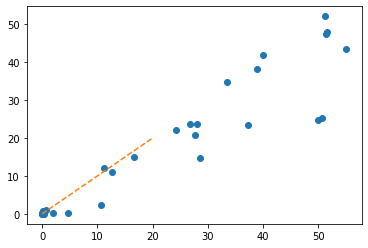

In [29]:
from matplotlib import pyplot as plt
import numpy as np
def ahi(TN,FP,FN,TP):
    ref_ahi=(TP+FN)/(TN+FP+FN+TP)*60
    pred_ahi=(TP+FP)/(TN+FP+FN+TP)*60
    #ref_ahi =1 if ref_ahi>=15 else 0
    #pred_ahi =1 if pred_ahi>=15 else 0
    acc=(TP+TN)/(TN+FP+FN+TP)
    return ref_ahi,pred_ahi,acc

ref_ahi_list,pred_ahi_list=[],[]
cfms=[[63,82,68,785],[120,39,469,390],[288,65,77,576],[54,6,148,523],
      [849,210,356,575],[531,71,107,299],[456,218,155,1188],[727,83,256,439],
      [156,9,424,395],[221,23,130,92],[125,90,187,1092],[751,46,72,142],
      [729,169,126,1010],[917,4,31,0],[1608,24,299,52],[808,12,9,1],
      [816,4,70,0],[952,0,0,0],[938,10,2,1],[930,0,0,0],
      [930,2,0,0],[735,0,4 ,0],[467,0,1,0],[586,0,2,0],
      [859,13,3,0],[245,15,38,171],[862,3,0,1],[700,49,75,211],
      [379,35,29,67],[329,61,294,342],[536,0,2,0],[143,11,78,863]]
for cfm in cfms:
    ref,pred,acc=ahi(cfm[0],cfm[1],cfm[2],cfm[3])
    ref_ahi_list.append(ref)
    pred_ahi_list.append(pred)
    print(ref,pred,acc)
plt.plot(np.array(ref_ahi_list),np.array(pred_ahi_list),'o')
plt.plot(np.arange(200)/10,np.arange(200)/10,'--')
plt.show()
plt.close("all")

In [27]:
490	20	470	9	12.5	57.1	69.6

0.9696969696969697

In [ ]:
# <!-- 
# [[ 63,82,68,785]]
# Subject 1 Current Train Acc:  0.900573793622425 Current Test Acc:  0.8496993987975
        
# [[120,39,469,390]]
# Subject 2 Current Train Acc:  0.919900856524331 Current Test Acc:  0.5009823182711
        
# [[288,65,77,576]]
# Subject 3 Current Train Acc:  0.9203387172651717 Current Test Acc:  0.858846918489
        
# [[54,6,148,523]]
# Subject 4 Current Train Acc:  0.9038246268656717 Current Test Acc:  0.789329685362
        
# [[849,210,356,575]]
# Subject 5 Current Train Acc:  0.8792595708876736 Current Test Acc:  0.715577889447
        
# [[531,71,107,299]]
# Subject 6 Current Train Acc:  0.9191732271116269 Current Test Acc:  0.823412698412

# [[456,218,155,1188]]
# Subject 7 Current Train Acc:  0.9160782535466736 Current Test Acc:  0.815071888943

# [[727,83,256 439]]
# Subject 8 Current Train Acc:  0.9239788440706047 Current Test Acc:  0.774750830564

# [[156,9,424 395]]
# Subject 9 Current Train Acc:  0.9102704735637948 Current Test Acc:  0.559959349593

# [[221,23,130,92]]
# Subject 10 Current Train Acc:  0.915065535851966 Current Test Acc:  0.671673819742

# [[125,90,187,1092]]
# Subject 11 Current Train Acc:  0.8126891104245628 Current Test Acc:  0.81459170013

# [[751,46,72,142]]
# Subject 12 Current Train Acc:  0.9123902132998746 Current Test Acc:  0.88328387734

# [[729,169,126,1010]]
# Subject 13 Current Train Acc:  0.9207635220533429 Current Test Acc:  0.85496558505

# [[917,4,31,0]]
# Subject 14 Current Train Acc:  0.9017189016562823 Current Test Acc:  0.96323529411

# [[1608,24,299,52]]
# Subject 15 Current Train Acc:  0.8769574220266597 Current Test Acc:  0.83711548159

# [[808,12,9,1]]
# Subject 16 Current Train Acc:  0.8277346308599233 Current Test Acc:  0.97469879518

# [[816,4,70,0]]
# Subject 17 Current Train Acc:  0.6041998687541015 Current Test Acc:  0.91685393258

# [[952,0,0,0]]
# Subject 18 Current Train Acc:  0.6013337925420332 Current Test Acc:  1.0

# [[938,10,2,1]]
# Subject 19 Current Train Acc:  0.843143393863494 Current Test Acc:  0.987381703470

# [[930,0,0,0]]
# Subject 20 Current Train Acc:  0.601795938800413 Current Test Acc:  1.0

# [[930,2,0,0]]
# Subject 21 Current Train Acc:  0.913670640508151 Current Test Acc:  0.997854077253

# [[735,0,4 ,0]]
# Subject 22 Current Train Acc:  0.604192585220204 Current Test Acc:  0.994587280108

# [[467,0,1,0]]
# Subject 23 Current Train Acc:  0.6074391635567344 Current Test Acc:  0.99786324786

# [[586,0,2,0]]
# Subject 24 Current Train Acc:  0.6060737392811814 Current Test Acc:  0.99659863945

# [[859,13,3,0]]
# Subject 25 Current Train Acc:  0.8617253873063468 Current Test Acc:  0.98171428571

# [[245,15,38,171]]
# Subject 26 Current Train Acc:  0.8416198877305533 Current Test Acc:  0.88699360341

# [[862,3,0,1]]
# Subject 27 Current Train Acc:  0.9092271662763466 Current Test Acc:  0.99653579676

# [[700,49,75,211]]
# Subject 28 Current Train Acc:  0.8718608739326972 Current Test Acc:  0.88019323671

# [[379,35,29,67]]
# Subject 29 Current Train Acc:  0.8907075136654211 Current Test Acc:  0.87450980392

# [[329,61,294,342]]
# Subject 30 Current Train Acc:  0.8053350070610388 Current Test Acc:  0.65399610136

# [[536,0,2,0]]
# Subject 31 Current Train Acc:  0.8903965629153402 Current Test Acc:  0.99628252788

# [[143,11,78,863]]
# Subject 32 Current Train Acc:  0.916467480186187 Current Test Acc:  0.918721461187 -->